In [17]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [18]:
# Manually maintain this list as you go
leverage_pairs = [
    ("AAPU", "AAPL"),
    ("AMUU", "AMD"),
    ("AMZU", "AMZN"),
    ("AVL", "AVGO"),
    ("BITX", "IBIT"),
    ("BOEU", "BA"),
    ("BRKU", "BRK-B"),
    ("BULU", "BULL"),
    ("CSCL", "CSCO"),
    ("ELIL", "LLY"),
    ("ETHU", "ETHA"),
    ("FRDU", "F"),
    ("GGLL", "GOOGL"),
    ("GMEU", "GME"),
    ("LMTL", "LMT"),
    ("METU", "META"),
    ("MUU", "MU"),
    ("MSFU", "MSFT"),
    ("MSTX", "MSTR"),
    ("NVDU", "NVDA"),
    ("NFXL", "NFLX"),
    ("PLTU", "PLTR"),
    ("PALU", "PANW"),
    ("QCMU", "QCOM"),
    ("SHPU", "SHOP"),
    ("TSMX", "TSM"),
    ("TSLL", "TSLA"),
    ("XOMX", "XOM"),
    ("XXRP", "XRP")
]

leverage_pairs_leverageshares = [
    ("AALG", "AAL"),
    ("ABNG", "ABNB"),
    ("ADBG", "ADBE"),
    ("AMDG", "AMD"),
    ("ARMG", "ARM"),
    ("ASMG", "ASML"),
    ("AVGG", "AVGO"),
    ("BAIG", "BBAI"),
    ("BEG", "BE"),
    ("BIDG", "BIDU"),
    ("BLSG", "BLSH"),
    ("BMNG", "BMNR"),
    ("BOEG", "BA"),
    ("BULG", "BULL"),
    ("CIFG", "CIFR"),
    ("CMGG", "CMG"),
    ("CNCG", "CNC"),
    ("COIG", "COIN"),
    ("COTG", "COST"),
    ("CRCG", "CRCL"),
    ("CRMG", "CRM"),
    ("CRWG", "CRWV"),
    ("DUOG", "DUOL"),
    ("FIGG", "FIG"),
    ("FUTG", "FUTU"),
    ("GEMG", "GEMI"),
    ("GEVG", "GEV"),
    ("GLGG", "GLXY"),
    ("GRAG", "GRAB"),
    ("HOOG", "HOOD"),
    ("IREG", "IREN"),
    ("KLAG", "KLAC"),
    ("LACG", "LAC"),
    ("LULG", "LULU"),
    ("MPG", "MP"),
    ("NBIG", "NBIS"),
    ("NEMG", "NEM"),
    ("NETG", "NET"),
    ("NIOG", "NIO"),
    ("NUG", "NU"),
    ("NVDG", "NVDA"),
    ("OKTG", "OKTA"),
    ("OPEG", "OPEN"),
    ("OSCG", "OSCR"),
    ("PANG", "PANW"),
    ("PBRG", "PBR"),
    ("PLTG", "PLTR"),
    ("PYPG", "PYPL"),
    ("RTXG", "RTX"),
    ("SATG", "SATS"),
    ("SBU", "SBUX"),
    ("SNAG", "SNAP"),
    ("SPOG", "SPOT"),
    ("TERG", "TER"),
    ("TSLG", "TSLA"),
    ("TSMG", "TSM"),
    ("UNHG", "UNH"),
    ("UPSG", "UPS"),
    ("VALG", "VALE"),
    ("XYZG", "XYZ"),
]

existing_underlyings = {und for _, und in leverage_pairs}

leverage_pairs_expanded = leverage_pairs + [
    (etf, und)
    for etf, und in leverage_pairs_leverageshares
    if und not in existing_underlyings
]

leverage_pairs_capped_accel = [
    ("COIO", "COIN"),
    ("MSOO", "MSTR"),
    ("NVDO", "NVDA"),
    ("PLOO", "PLTR"),
    ("TSLO", "TSLA"),
]

# If you want to allow duplicates by underlying, do NOT filter on underlying.
# Just concatenate all sources.
leverage_pairs_expanded_expanded = (
    leverage_pairs_expanded
    + leverage_pairs_capped_accel
)

dx_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in leverage_pairs_expanded_expanded
    ]
)

dx_df["Leverage"] = 2.0   # 2x for these dx leveraged products

In [19]:
covered_call_pairs_expanded = [
    ("QYLD", "QQQ"),   # Global X full overwrite
    ("QYLG", "QQQ"),   # 50% overwrite
    ("QQQX", "QQQ"),   # Nuveen dynamic overwrite
    ("JEPQ", "QQQ"),   # JPM active Nasdaq covered-call
    ("XYLD", "SPY"),   # S&P 500 buy-write
    ("XYLG", "SPY"),   # 50% overwrite
    ("JEPI", "SPY"),   # JPM ELN-based premium income
    ("SPYI", "SPY"),   # NEOS buy-write
    ("RYLD", "IWM"),   # Russell 2000 buy-write
]

cc_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in covered_call_pairs_expanded
    ]
)

cc_df["Leverage"] = 1.0   # treat covered calls as 1x


session = requests.Session()
session.headers.update(
    {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }
)

def get_yieldmax_single_stock_map():
    """
    Scrapes the YieldMax Single Stock Option Income ETFs page and extracts
    (ETF ticker, underlying stock) from the ETF name, e.g.:

        Ticker:  TSLY
        Name:    'YieldMax TSLA Option Income Strategy ETF'
        -> underlying = TSLA

    Returns: DataFrame with columns [Provider, ETF, Underlying]
    """
    base = "https://yieldmaxetfs.com"
    url = base + "/nav-group/yieldmax-single-stock-option-income-etfs/"

    resp = session.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    # For each link that looks like a ticker, find the nearby 'YieldMax ...' name
    for a in soup.find_all("a", href=True):
        ticker = a.get_text(strip=True)

        # Tickers are 3–5 uppercase letters (ABNY, TSLY, NVDY, etc.)
        if not re.fullmatch(r"[A-Z]{3,5}", ticker):
            continue

        # Find the ETF name text that follows this ticker
        name_node = a.find_next(string=re.compile(r"^YieldMax "))
        if not name_node:
            continue

        etf_name = name_node.strip()

        # Try to extract underlying from the name:
        # 'YieldMax TSLA Option Income Strategy ETF' -> TSLA
        # 'YieldMax AMZN Option Income ETF'         -> AMZN
        m = re.search(r"YieldMax\s+([A-Z\.]{2,6})\s+Option Income", etf_name)
        if not m:
            continue

        underlying = m.group(1)

        rows.append(("YieldMax", ticker, underlying))

    df = pd.DataFrame(rows, columns=["Provider", "ETF", "Underlying"])
    df = df.drop_duplicates().sort_values(["Provider", "ETF"]).reset_index(drop=True)
    df = df.drop(columns=["Provider"])
    return df

ym_df = get_yieldmax_single_stock_map()
ym_df["Leverage"] = 1.0   # treat YieldMax as 1x (income overlay, not levered beta)



In [20]:
all_df = pd.concat([dx_df, cc_df, ym_df], ignore_index=True)
# make sure to exclude jp morgan
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs or duplicate rows if needed
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)
# Replace dots with dashes for Yahoo Finance compatibility
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# Now create clean ticker lists
all_tickers = all_df["ETF"].tolist()
all_underlyings = all_df["Underlying"].tolist()

# UNIQUE list of underlyings
all_underlyings_unique = sorted(set(all_underlyings))

print("Clean DataFrame:")
print(all_df)

print("\nUnique underlyings:")
print(all_underlyings_unique)

Clean DataFrame:
      ETF Underlying  Leverage
0    AAPU       AAPL       2.0
1    AMUU        AMD       2.0
2    AMZU       AMZN       2.0
3     AVL       AVGO       2.0
4    BITX       IBIT       2.0
..    ...        ...       ...
123  SNOY       SNOW       1.0
124  TSLY       TSLA       1.0
125  TSMY        TSM       1.0
126  XOMO        XOM       1.0
127  XYZY        XYZ       1.0

[128 rows x 3 columns]

Unique underlyings:
['AAL', 'AAPL', 'ABNB', 'ADBE', 'AI', 'AMD', 'AMZN', 'ARM', 'ASML', 'AVGO', 'BA', 'BABA', 'BBAI', 'BE', 'BIDU', 'BLSH', 'BMNR', 'BRK-B', 'BULL', 'CIFR', 'CMG', 'CNC', 'COIN', 'COST', 'CRCL', 'CRM', 'CRWV', 'CSCO', 'CVNA', 'DIS', 'DKNG', 'DUOL', 'ETHA', 'F', 'FIG', 'FUTU', 'GEMI', 'GEV', 'GLXY', 'GME', 'GOOGL', 'GRAB', 'HIMS', 'HOOD', 'IBIT', 'IREN', 'IWM', 'JPM', 'KLAC', 'LAC', 'LLY', 'LMT', 'LULU', 'MARA', 'META', 'MP', 'MRNA', 'MSFT', 'MSTR', 'MU', 'NBIS', 'NEM', 'NET', 'NFLX', 'NIO', 'NU', 'NVDA', 'OKTA', 'OPEN', 'OSCR', 'PANW', 'PBR', 'PLTR', 'PYPL', 'QCOM

In [21]:
# 1. Start from your cleaned all_df (as you already defined)
all_df = pd.concat([dx_df, cc_df, ym_df], ignore_index=True)

all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)

# Replace dots with dashes for Yahoo/IB style tickers
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# 2. Build the universe_df with just the fields we care about
universe_cols = ["Underlying", "ETF", "Leverage"]
universe_df = all_df[universe_cols].copy()

# (optional) sort for readability
universe_df = universe_df.sort_values(["Underlying", "ETF"]).reset_index(drop=True)

print("Universe DataFrame:")
print(universe_df.head())

# 3. Export to CSV
universe_df.to_csv("etf_universe.csv", index=False)
print("\nSaved ETF universe to etf_universe.csv")


Universe DataFrame:
  Underlying   ETF  Leverage
0        AAL  AALG       2.0
1       AAPL  AAPU       2.0
2       AAPL  APLY       1.0
3       ABNB  ABNG       2.0
4       ABNB  ABNY       1.0

Saved ETF universe to etf_universe.csv


In [22]:
pd.DataFrame({"ticker": all_tickers}).to_csv("tickers.csv", index=False)


In [23]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [24]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [25]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.2319,0.4081,4100000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.3732,0.2668,4400000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-0.1984,3.8384,10000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-95.5696,99.2096,20000,BBG01W275XX6
4,AAAU,USD,GOLDMAN SACHS PHYSICAL GOLD,458886642.0,XXXXXXXK1034,3.1245,0.5155,550000,BBG00LPXX872


In [26]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [27]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [28]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'AALG': 0.169644,
 'AAPU': 0.047779999999999996,
 'ABNG': 0.1507,
 'ABNY': 0.061121999999999996,
 'ADBG': 0.359082,
 'AIYY': 0.013458,
 'AMDY': 0.194118,
 'AMUU': 0.009974000000000004,
 'AMZU': 0.077638,
 'AMZY': 0.0,
 'APLY': 0.042684,
 'ARMG': 0.37989399999999995,
 'ASMG': 0.03833,
 'AVL': 0.156634,
 'BABO': 0.0,
 'BAIG': 0.28998399999999996,
 'BIDG': 0.0,
 'BITX': 0.070062,
 'BLSG': 2.050134,
 'BMNG': 0.251902,
 'BOEU': 0.128544,
 'BRKC': 0.014034,
 'BRKU': 0.043182,
 'BULU': 0.31617,
 'CIFG': 0.0,
 'CMGG': 0.068234,
 'COIG': 0.129228,
 'COIO': 0.28871800000000003,
 'CONY': 0.09019,
 'COTG': 0.22815200000000002,
 'CRCG': 0.26675000000000004,
 'CRCO': 0.432794,
 'CRMG': 0.023732000000000003,
 'CRWG': 0.12905,
 'CSCL': 0.025227999999999997,
 'CVNY': 0.147948,
 'DISO': 0.23621199999999998,
 'DRAY': 0.045156,
 'ELIL': 0.052372,
 'ETHU': 0.022948,
 'FBY': 0.0,
 'FIGG': 0.380966,
 'FUTG': 0.174396,
 'GGLL': 0.035128,
 'GLGG': 0.531508,
 'GMEU': 0.4566,
 'GOOY': 0.032408,
 'GRAG': 1.14118

In [29]:
available_map

{'AALG': 5000,
 'AAPU': 30000,
 'ABNG': 600,
 'ABNY': 2000,
 'ADBG': 200000,
 'AIYY': 20000,
 'AMDY': 300000,
 'AMUU': 45000,
 'AMZU': 45000,
 'AMZY': 200000,
 'APLY': 40000,
 'ARMG': 50000,
 'ASMG': 3000,
 'AVL': 65000,
 'BABO': 70000,
 'BAIG': 40000,
 'BIDG': 200,
 'BITX': 550000,
 'BLSG': 500,
 'BMNG': 250000,
 'BOEU': 5000,
 'BRKC': 3000,
 'BRKU': 1000,
 'BULU': 10000,
 'CIFG': 44,
 'CMGG': 1000,
 'COIG': 15000,
 'COIO': 200,
 'CONY': 300000,
 'COTG': 45000,
 'CRCG': 700000,
 'CRCO': 15000,
 'CRMG': 95000,
 'CRWG': 1000000,
 'CSCL': 7000,
 'CVNY': 99,
 'DISO': 10000,
 'DRAY': 1000,
 'ELIL': 10000,
 'ETHU': 700000,
 'FBY': 90000,
 'FIGG': 25000,
 'FUTG': 8000,
 'GGLL': 550000,
 'GLGG': 15000,
 'GMEU': 15000,
 'GOOY': 300000,
 'GRAG': 300,
 'HIYY': 1000,
 'HOOG': 25000,
 'HOOY': 35000,
 'JEPI': 1300000,
 'JEPQ': 1400000,
 'JPMO': 10000,
 'KLAG': 200,
 'LACG': 300,
 'LMTL': 700,
 'LULG': 1000,
 'MARO': 80000,
 'METU': 850000,
 'MPG': 20000,
 'MRNY': 5000,
 'MSFO': 45000,
 'MSFU': 2500

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [31]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret


def portfolio_returns(long_ret: pd.Series,
                      etf_ret: pd.Series,
                      w_long: float,
                      w_short: float,
                      borrow_annual: float = 0.0,
                      trading_days: int = 252) -> pd.Series:
    """
    Combine long underlying + short ETF (via negative w_short).
    long_ret, etf_ret: daily simple returns of LONG legs (total return)
    w_long:  weight on underlying
    w_short: weight on ETF (negative for short)
    borrow_annual: annualized borrow cost for the ETF (decimal, e.g. 0.37)
    """
    borrow_daily = borrow_annual / trading_days

    df = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if df.empty:
        return pd.Series(dtype=float)

    # Portfolio return including borrow drag
    port_ret = (
        w_long * df["long"] +
        w_short * df["etf"] -
        abs(w_short) * borrow_daily
    )
    port_ret.name = "port_ret"
    return port_ret



def worst_rolling_window(ret_series, window=60):
    """
    Numerically stable worst rolling-window cumulative return.
    ret_series: daily returns in decimal form (0.01 = 1%).
    
    Returns:
        worst_cum_ret: float (e.g. -0.35 for -35%)
        worst_end_date: index label corresponding to the *end* of that window
    """
    # Keep the original index intact
    r = pd.Series(ret_series)

    # If too short, bail
    if r.dropna().shape[0] < window:
        return np.nan, None

    # Safety: if returns look like percentages (5 = 500%), scale them
    # We DON'T want to change the index, only the values.
    if r.abs().max() > 2:  # heuristic threshold
        r = r / 100.0

    # Use log(1+r) for stability
    log_g = np.log1p(r)  # this will propagate NaNs
    # rolling sum of logs, aligning the result to the *right* edge (default)
    roll_log = log_g.rolling(window=window, min_periods=window).sum()

    # Convert back from log-space: exp(sum log) - 1
    roll_cum = np.expm1(roll_log)

    # Drop NaNs (these correspond to windows that weren't full)
    roll_cum_valid = roll_cum.dropna()
    if roll_cum_valid.empty:
        return np.nan, None

    worst = roll_cum_valid.min()
    worst_end_date = roll_cum_valid.idxmin()  # this is the *end* of the window

    return float(worst), worst_end_date


def margin_call_probability(port_ret, margin_level=0.25):
    """
    Simple margin-call metric: equity starts at 1.0,
    margin call if equity < margin_level at any point.
    Returns (probability_over_days, first_call_date).
    """
    equity = (1 + port_ret).cumprod()
    calls = equity < margin_level
    if not calls.any():
        return 0.0, None
    prob = calls.mean()
    first_call_date = equity.index[calls.argmax()]
    return float(prob), first_call_date



In [32]:
def simulate_pair_monte_carlo(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
    half_life_days=None,   # NEW: if set, use EWM stats
):
    rng = np.random.default_rng(random_state)

    # Align returns into one DataFrame
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    if half_life_days is None:
        # Plain historical mean & cov (equal weights)
        mu  = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        # Exponentially weighted mean & cov, emphasizing recent data
        # EWM mean: take the last row of the EWM mean process
        ew_mean = ret_mat.ewm(halflife=half_life_days, adjust=False).mean()
        mu = ew_mean.iloc[-1].values

        # EWM covariance: same idea
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        # ew_cov is a MultiIndex (date, column); get the last date slice
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []
    sim_dds   = []
    # mc_prob_mc = 0  # if you later add margin-call MC stats

    for _ in range(n_sims):
        # Simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0

        cum_curve = (1 + sim_port).cumprod()
        peak = np.maximum.accumulate(cum_curve)
        dd = (cum_curve / peak - 1.0).min()

        sim_cagrs.append(cagr)
        sim_dds.append(dd)

    sim_cagrs = np.array(sim_cagrs)
    sim_dds   = np.array(sim_dds)

    stats = {
        "mc_cagr_p50": np.percentile(sim_cagrs, 50),
        "mc_cagr_p10": np.percentile(sim_cagrs, 10),
        "mc_cagr_p90": np.percentile(sim_cagrs, 90),
        "mc_dd_p50":   np.percentile(sim_dds, 50),
        "mc_dd_p10":   np.percentile(sim_dds, 10),
        "mc_dd_p90":   np.percentile(sim_dds, 90),
    }

    return stats


In [33]:
def analyze_pairs_with_mc(
    all_df,
    start=None,
    end=None,
    w_long=1.0,
    w_short=1.0,
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=1000,
    borrow_map=None,
    default_borrow=0.05,
    trading_days=252,
):
    """
    For each pair in all_df (with columns ["ETF", "Underlying", optional "Leverage"]):

      - We interpret the function arguments w_long, w_short as BASE weights.
        For each pair we then set:
            w_long_pair  =  + w_long               (e.g. +1.0)
            w_short_pair =  - w_short / Leverage   (e.g. -1.0 / 2.0 = -0.5 for a 2x ETF)

        So calling with w_long = 1.0, w_short = 1.0:
            1x underlying, short (1 / Leverage)x ETF.

      - Build total-return price series for Underlying and ETF (long TR).
      - Compute historical stats for legs and portfolio (including borrow drag).
      - Run Monte Carlo using the SAME pair-specific weights.
    """
    results = []

    # Keep the base weights so we don't shadow them inside the loop
    base_w_long = float(w_long)
    base_w_short = float(w_short)

    for _, row in all_df.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]
        lev = float(row.get("Leverage", 1.0))  # default 1x if missing

        # Pair-specific weights based on leverage
        w_long_pair = base_w_long
        w_short_pair = -base_w_short / lev   # short scaled by leverage

        print(
            f"\nProcessing pair: LONG {und} / SHORT {etf} "
            f"(leverage={lev}, w_long={w_long_pair}, w_short={w_short_pair})"
        )

        # Long total-return prices for both legs
        prices_long = get_total_return_series(und, start=start, end=end)
        prices_etf  = get_total_return_series(etf, start=start, end=end)

        if prices_long.empty or prices_etf.empty:
            print(" → SKIPPED: missing data")
            continue

        long_stats, long_ret = compute_leg_stats(prices_long, trading_days=trading_days)
        etf_stats, etf_ret   = compute_leg_stats(prices_etf, trading_days=trading_days)

        if long_stats is None or etf_stats is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Historical leg stats (both are long TR stats)
        cagr_long = long_stats["cagr"]
        cagr_etf  = etf_stats["cagr"]
        vol_long  = long_stats["vol_annual"]
        vol_etf   = etf_stats["vol_annual"]

        # Borrow rate for this ETF
        if borrow_map is not None:
            borrow_annual = borrow_map.get(
                etf, borrow_map.get("default", default_borrow)
            )
        else:
            borrow_annual = default_borrow

        # Portfolio historical daily returns (includes borrow)
        port_ret = portfolio_returns(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            trading_days=trading_days,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Historical portfolio stats
        T = len(port_ret)
        cumulative_port = (1 + port_ret).prod()
        cagr_port = cumulative_port ** (trading_days / T) - 1.0
        vol_port = port_ret.std() * np.sqrt(trading_days)

        worst60_long, worst60_long_end = worst_rolling_window(long_ret, window=60)
        worst60_port, worst60_port_end = worst_rolling_window(port_ret, window=60)

        # Risk differentials (historical)
        vol_diff_abs = vol_port - vol_long
        vol_diff_ratio = vol_port / vol_long if vol_long != 0 else np.nan
        worst60_diff_abs = worst60_port - worst60_long

        # Margin-call probability on historical path
        mc_prob_hist, mc_first_hist = margin_call_probability(
            port_ret, margin_level=margin_level
        )

        # Monte Carlo simulation for this pair using SAME weights
        mc_stats = simulate_pair_monte_carlo(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=252
        )

        if mc_stats is None:
            print(" → SKIPPED: MC failed")
            continue

        out_row = {
            "ETF": etf,
            "Underlying": und,
            "Leverage": lev,
            "w_long": w_long_pair,
            "w_short": w_short_pair,

            # Historical leg stats
            "cagr_long_hist": cagr_long,
            "cagr_etf_hist": cagr_etf,
            "vol_long_hist": vol_long,
            "vol_etf_hist": vol_etf,

            # Historical portfolio stats
            "cagr_port_hist": cagr_port,
            "vol_port_hist": vol_port,
            "worst60_long_hist": worst60_long,
            "worst60_port_hist": worst60_port,
            "worst60_long_end": worst60_long_end,
            "worst60_port_end": worst60_port_end,

            # Historical risk difference metrics
            "vol_diff_abs": vol_diff_abs,
            "vol_diff_ratio": vol_diff_ratio,
            "worst60_diff_abs": worst60_diff_abs,

            # Historical margin-call metric
            "mc_prob_hist": mc_prob_hist,
            "mc_first_hist": mc_first_hist,

            # Borrow info
            "borrow_annual": borrow_annual,
        }

        # Merge in Monte Carlo stats
        out_row.update(mc_stats)

        results.append(out_row)

    return pd.DataFrame(results)


In [34]:
results_df_mc = analyze_pairs_with_mc(
    all_df,
    w_long=1.0,
    w_short=1.0,
    borrow_map=borrow_map,
    default_borrow=borrow_map['default'],
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=5000,
)



Processing pair: LONG AAPL / SHORT AAPU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMD / SHORT AMUU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMZN / SHORT AMZU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AVGO / SHORT AVL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG IBIT / SHORT BITX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BA / SHORT BOEU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BRK-B / SHORT BRKU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BULL / SHORT BULU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG CSCO / SHORT CSCL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG LLY / SHORT ELIL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ETHA / SHORT ETHU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG F / SHORT FRDU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG 

In [36]:
# Build etf_cagr.csv with mapping + CAGR
etf_cagr = results_df_mc[[
    "ETF",
    "Underlying",
    "Leverage",          # from analyze_pairs_with_mc
    "cagr_port_hist",
]].copy()

# Turn numeric leverage into LevType string: 2x vs CC
def levtype_from_leverage(x):
    try:
        x = float(x)
    except (TypeError, ValueError):
        return "CC"
    if x >= 1.5:
        return "2x"
    else:
        return "CC"

etf_cagr["LevType"] = etf_cagr["Leverage"].apply(levtype_from_leverage)

# Optional: clean tickers (match what you're doing elsewhere)
etf_cagr["ETF"] = etf_cagr["ETF"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
etf_cagr["Underlying"] = etf_cagr["Underlying"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()

# Save file used by the FTP screening script and the trading algo
from pathlib import Path

# Resolve repo root (one folder up from current file / notebook)
repo_root = Path.cwd().parent

config_dir = repo_root / "config"
config_dir.mkdir(parents=True, exist_ok=True)

out_path = config_dir / "etf_cagr.csv"

etf_cagr.to_csv(out_path, index=False)
print(f"Saved to {out_path}")
print(etf_cagr.head())



Saved to c:\Users\werdn\Documents\Investing\ls-algo\config\etf_cagr.csv
    ETF Underlying  Leverage  cagr_port_hist LevType
0  AAPU       AAPL       2.0        0.023916      2x
1  AMUU        AMD       2.0        0.055163      2x
2  AMZU       AMZN       2.0        0.039463      2x
3   AVL       AVGO       2.0       -0.020330      2x
4  BITX       IBIT       2.0        0.076115      2x


In [37]:
pd.set_option('display.max_columns', None)

# Optional: Also set option to display all rows
pd.set_option('display.max_rows', None)

results_df_mc.sort_values("cagr_port_hist", ascending=False)

,ETF,Underlying,Leverage,w_long,w_short,cagr_long_hist,cagr_etf_hist,vol_long_hist,vol_etf_hist,cagr_port_hist,vol_port_hist,worst60_long_hist,worst60_port_hist,worst60_long_end,worst60_port_end,vol_diff_abs,vol_diff_ratio,worst60_diff_abs,mc_prob_hist,mc_first_hist,borrow_annual,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
77,TSLO,TSLA,2.0,1.0,-0.5,0.447467,0.765400,0.578194,0.430666,0.846724,0.294013,-0.588690,0.001078,2022-12-27 00:00:00-05:00,2025-12-11 00:00:00-05:00,-0.284181,0.508502,0.589768,0.0,None,0.226258,-0.669468,-0.712204,-0.621369,-0.996196,-0.998087,-0.992506
103,HOOY,HOOD,1.0,1.0,-1.0,0.329386,1.456025,0.742103,0.499961,0.539239,0.182448,-0.671974,0.042795,2022-01-21 00:00:00-05:00,2025-12-15 00:00:00-05:00,-0.559655,0.245852,0.714769,0.0,None,0.038456,-0.381986,-0.431270,-0.325936,-0.913041,-0.942634,-0.867665
111,PLTY,PLTR,1.0,1.0,-1.0,0.778003,1.411322,0.709582,0.548689,0.443582,0.180040,-0.537651,-0.035129,2022-01-27 00:00:00-05:00,2025-12-17 00:00:00-05:00,-0.529542,0.253727,0.502521,0.0,None,0.093868,44.912582,37.599762,53.991535,-0.075634,-0.097658,-0.060573
18,MSTX,MSTR,2.0,1.0,-0.5,0.105121,-0.575872,0.753655,1.681181,0.274339,0.057300,-0.921494,0.023412,2000-06-01 00:00:00-04:00,2025-03-28 00:00:00-04:00,-0.696355,0.076030,0.944906,0.0,None,0.050000,0.227282,0.200067,0.256730,-0.020860,-0.027924,-0.016100
28,XXRP,XRP,2.0,1.0,-0.5,-0.519728,-0.662184,0.836067,1.449051,0.271310,0.046359,NaN,NaN,NaT,NaT,-0.789707,0.055449,NaN,0.0,None,0.012710,0.031672,0.012102,0.052432,-0.048222,-0.074475,-0.033145
94,CONY,COIN,1.0,1.0,-1.0,-0.062934,0.276199,0.862461,0.589859,0.263737,0.251577,-0.754657,-0.115353,2022-06-30 00:00:00-04:00,2024-10-10 00:00:00-04:00,-0.610884,0.291696,0.639304,0.0,None,0.090190,0.044051,-0.073416,0.181955,-0.367415,-0.538740,-0.246264
92,BABO,BABA,1.0,1.0,-1.0,0.048132,0.348433,0.421864,0.370240,0.234263,0.139040,-0.365069,-0.072671,2022-03-14 00:00:00-04:00,2024-12-27 00:00:00-05:00,-0.282825,0.329584,0.292398,0.0,None,0.000000,-0.255097,-0.303502,-0.201221,-0.779409,-0.841624,-0.692160
88,AIYY,AI,1.0,1.0,-1.0,-0.312489,-0.393210,0.832394,0.490241,0.207579,0.241991,-0.666469,-0.108647,2021-05-06 00:00:00-04:00,2025-04-17 00:00:00-04:00,-0.590403,0.290717,0.557823,0.0,None,0.013458,0.447645,0.298362,0.620734,-0.179315,-0.249970,-0.132864
66,SATG,SATS,2.0,1.0,-0.5,0.080875,63.936411,0.453587,1.037305,0.166234,0.011028,-0.584713,NaN,2008-11-20 00:00:00-05:00,NaT,-0.442558,0.024314,NaN,0.0,None,0.050000,-0.005067,-0.011683,0.001729,-0.041409,-0.067566,-0.023414
118,TSMY,TSM,1.0,1.0,-1.0,0.174133,0.338609,0.435865,0.333957,0.153872,0.113585,-0.604874,-0.088132,2002-10-09 00:00:00-04:00,2025-04-21 00:00:00-04:00,-0.322280,0.260597,0.516742,0.0,None,0.000000,-0.500114,-0.531946,-0.465465,-0.969060,-0.977703,-0.956907


C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\146194658.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_sorted["PairLabel"], rotation=60, ha="right")


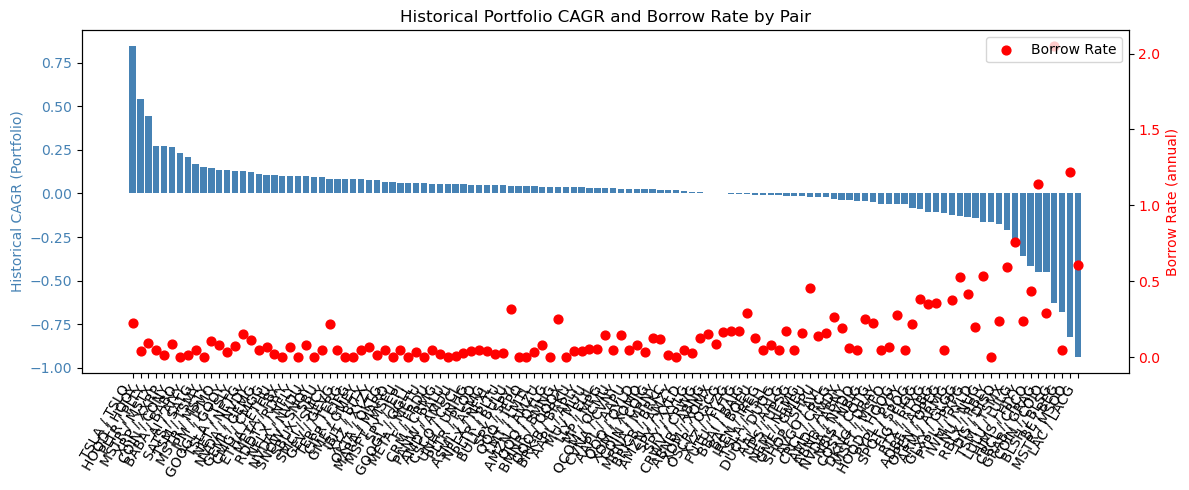

In [38]:
# Create a compact label like "NVDA / NVDU"
results_df_mc["PairLabel"] = results_df_mc["Underlying"] + " / " + results_df_mc["ETF"]

# Sort by historical portfolio CAGR
df_sorted = results_df_mc.sort_values("cagr_port_hist", ascending=False)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar chart: historical CAGR
bars = ax1.bar(df_sorted["PairLabel"], df_sorted["cagr_port_hist"], color="steelblue")
ax1.set_ylabel("Historical CAGR (Portfolio)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.set_xticklabels(df_sorted["PairLabel"], rotation=60, ha="right")
ax1.set_title("Historical Portfolio CAGR and Borrow Rate by Pair")

# Secondary axis for borrow rate
ax2 = ax1.twinx()
ax2.scatter(
    df_sorted["PairLabel"],
    df_sorted["borrow_annual"],
    color="red",
    s=40,
    label="Borrow Rate"
)
ax2.set_ylabel("Borrow Rate (annual)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Optional: add legend for borrow rate
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


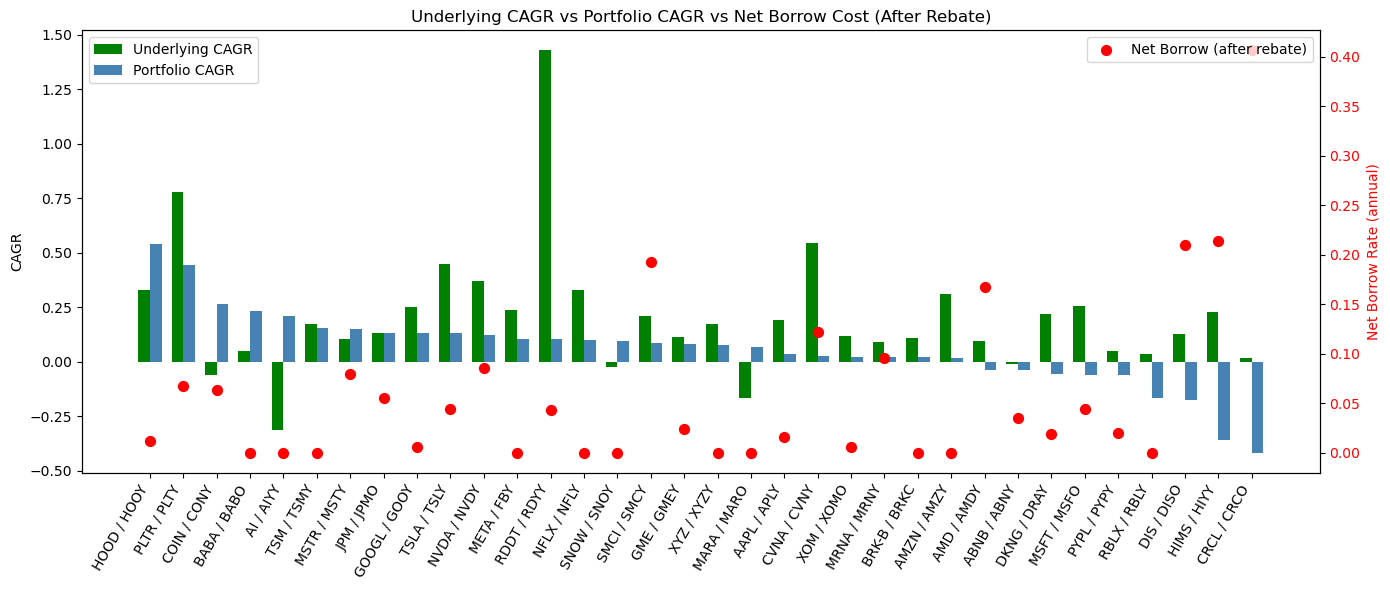

In [39]:
# Restrict to YieldMax tickers only
ym_etfs = set(ym_df["ETF"].unique())
df = results_df_mc[results_df_mc["ETF"].isin(ym_etfs)].copy()

# Drop rows with ANY NaNs in the relevant columns
df = df.dropna(subset=["cagr_long_hist", "cagr_port_hist", "borrow_annual"])

# --- Apply rebate adjustment ---
risk_free = 0.053         # 5.3% Fed Funds
rebate_fraction = 0.50
rebate_rate = rebate_fraction * risk_free   # ≈ 2.65%

df["net_borrow"] = df["borrow_annual"] - rebate_rate
df["net_borrow"] = df["net_borrow"].clip(lower=0)  # no negative borrow cost

# Make compact label like: "NVDA / NVDY"
df["PairLabel"] = df["Underlying"] + " / " + df["ETF"]

# Sort by portfolio CAGR
df_sorted = df.sort_values("cagr_port_hist", ascending=False)

# Extract data
labels = df_sorted["PairLabel"]
under_cagr = df_sorted["cagr_long_hist"]
port_cagr = df_sorted["cagr_port_hist"]
net_borrow = df_sorted["net_borrow"]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Underlying vs Portfolio CAGR bars ---
ax1.bar(x - width/2, under_cagr, width, label="Underlying CAGR", color="green")
ax1.bar(x + width/2, port_cagr, width, label="Portfolio CAGR", color="steelblue")

ax1.set_ylabel("CAGR", color="black")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=60, ha="right")
ax1.set_title("Underlying CAGR vs Portfolio CAGR vs Net Borrow Cost (After Rebate)")
ax1.legend(loc="upper left")

# --- Secondary axis (Net Borrow Rate) ---
ax2 = ax1.twinx()
ax2.scatter(x, net_borrow, color="red", s=50, label="Net Borrow (after rebate)")
ax2.set_ylabel("Net Borrow Rate (annual)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [40]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Filter YieldMax only
ym_etfs = set(ym_df["ETF"].unique())
df = results_df_mc[results_df_mc["ETF"].isin(ym_etfs)].copy()
df = df.dropna(subset=["cagr_port_hist", "cagr_long_hist"])

X = df["cagr_long_hist"].values.reshape(-1, 1)
y = df["cagr_port_hist"].values

model = LinearRegression().fit(X, y)

beta = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print("Slope (beta):", beta)
print("Intercept:", intercept)
print("R^2:", r2)


Slope (beta): 0.12622458388217223
Intercept: 0.03255911687812739
R^2: 0.041288581243657974


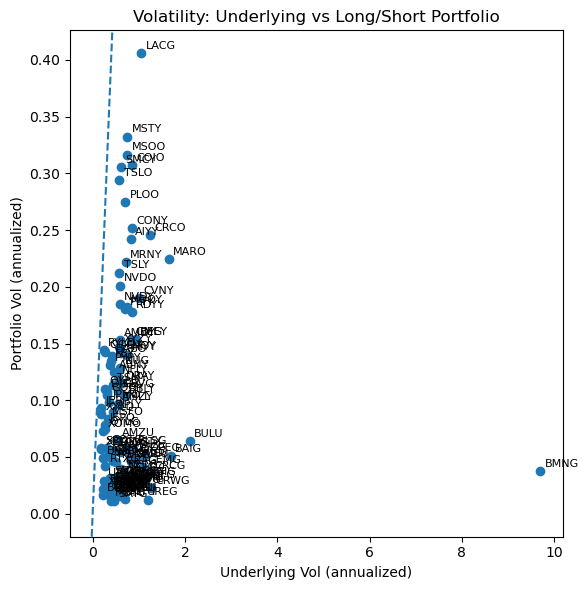

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(results_df_mc["vol_long_hist"], results_df_mc["vol_port_hist"])

for _, row in results_df_mc.iterrows():
    plt.annotate(
        row["ETF"],
        (row["vol_long_hist"], row["vol_port_hist"]),
        fontsize=8,
        xytext=(3, 3),
        textcoords="offset points",
    )

plt.xlabel("Underlying Vol (annualized)")
plt.ylabel("Portfolio Vol (annualized)")
plt.title("Volatility: Underlying vs Long/Short Portfolio")
plt.axline((0, 0), slope=1, linestyle="--")  # 45° line for parity
plt.tight_layout()
plt.show()


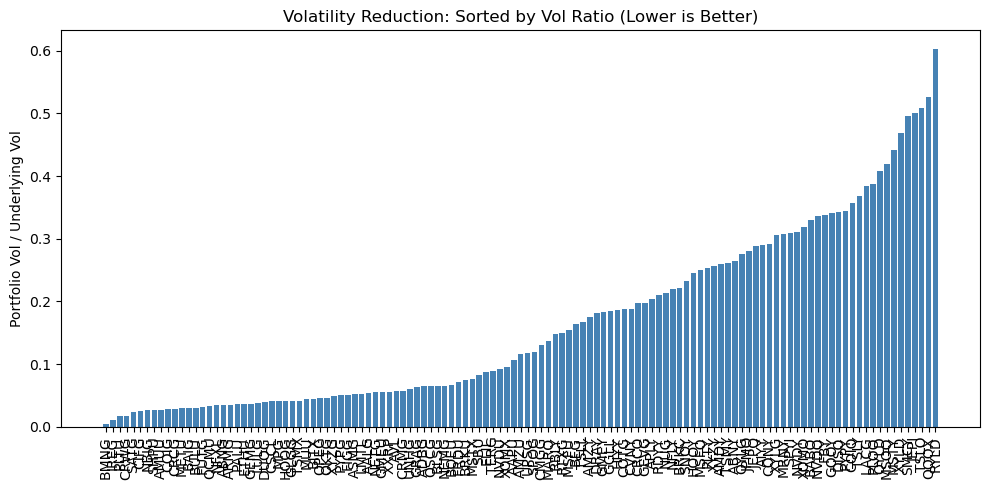

In [42]:
# Compute volatility ratio: Portfolio vol / Underlying vol
results_df_mc["vol_ratio"] = (
    results_df_mc["vol_port_hist"] / results_df_mc["vol_long_hist"]
)

# Sort by lowest ratio (most volatility reduction)
vol_ratio_sorted = results_df_mc.sort_values("vol_ratio")
vol_ratio_sorted[["ETF", "Underlying", "vol_ratio"]]
plt.figure(figsize=(10, 5))

plt.bar(
    vol_ratio_sorted["ETF"],
    vol_ratio_sorted["vol_ratio"],
    color="steelblue"
)

plt.xticks(rotation=90)
plt.ylabel("Portfolio Vol / Underlying Vol")
plt.title("Volatility Reduction: Sorted by Vol Ratio (Lower is Better)")
plt.tight_layout()
plt.show()


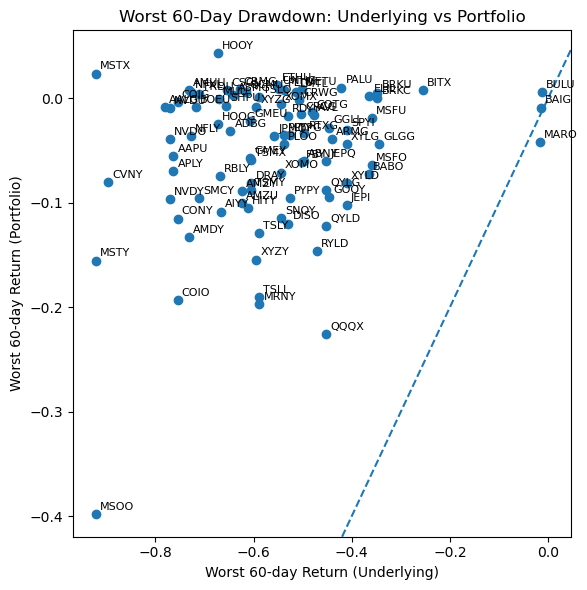

In [43]:
plt.figure(figsize=(6, 6))
plt.scatter(results_df_mc["worst60_long_hist"], results_df_mc["worst60_port_hist"])

for _, row in results_df_mc.iterrows():
    plt.annotate(
        row["ETF"],
        (row["worst60_long_hist"], row["worst60_port_hist"]),
        fontsize=8,
        xytext=(3, 3),
        textcoords="offset points",
    )

plt.xlabel("Worst 60-day Return (Underlying)")
plt.ylabel("Worst 60-day Return (Portfolio)")
plt.title("Worst 60-Day Drawdown: Underlying vs Portfolio")
plt.axline((0, 0), slope=1, linestyle="--")
plt.tight_layout()
plt.show()


In [44]:
def simulate_pair_mc_full(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
):
    """
    Alternative MC for a single pair that returns the full array of simulated CAGRs
    (instead of just percentiles).
    """
    rng = np.random.default_rng(random_state)

    # historical joint returns (long underlying, long ETF)
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    mu  = ret_mat.mean().values
    cov = ret_mat.cov().values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        # simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        # portfolio daily returns with borrow drag
        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0
        sim_cagrs.append(cagr)

    return np.array(sim_cagrs)


MSTR / MSTX
Mean CAGR: 0.27656000975118905
P10: 0.23607879236713786
P50 (median): 0.2753694859959118
P90: 0.3184563429841247


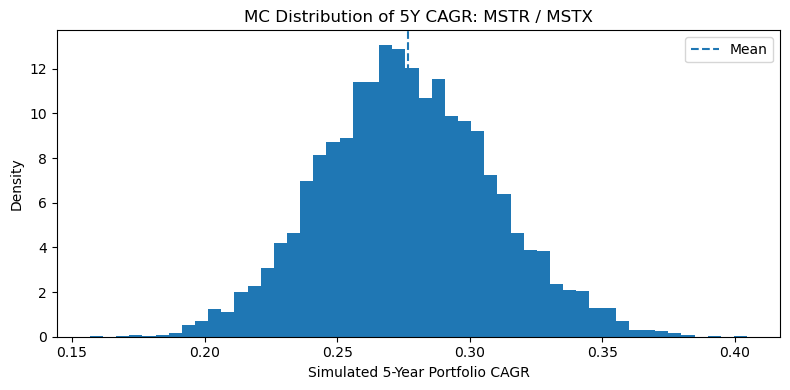

In [45]:
etf = "MSTX"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def compute_beta(etf, underlying, start=None, end=None):
    # Download prices
    data = yf.download([etf, underlying], period='max')["Close"].dropna()

    # Compute daily returns
    ret = data.pct_change().dropna()
    etf_ret = ret[etf].values.reshape(-1, 1)
    und_ret = ret[underlying].values.reshape(-1, 1)

    # Run linear regression: ETF_ret ~ beta * Underlying_ret
    model = LinearRegression().fit(und_ret, etf_ret)
    beta = model.coef_[0][0]
    alpha = model.intercept_[0]

    return beta, alpha, ret

# Example: PLTY / PLTR
beta, alpha, ret = compute_beta("PLTY", "PLTR")
print("Beta (PLTY vs PLTR):", beta)
print("Alpha:", alpha)

beta, alpha, ret = compute_beta("GOOY", "GOOGL")
print("Beta (GOOY vs GOOGL):", beta)
print("Alpha:", alpha)


C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\237220497.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([etf, underlying], period='max')["Close"].dropna()
[*********************100%***********************]  2 of 2 completed
C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\237220497.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([etf, underlying], period='max')["Close"].dropna()


Beta (PLTY vs PLTR): 0.7867983147392109
Alpha: -0.0006332774342172574


[*********************100%***********************]  2 of 2 completed

Beta (GOOY vs GOOGL): 0.7397750489013025
Alpha: -0.00023757366546593597


PLTR / PLTY
Mean CAGR: 0.45689911201208827
P10: 0.3116767683504049
P50 (median): 0.4507703905153352
P90: 0.6093718169818956


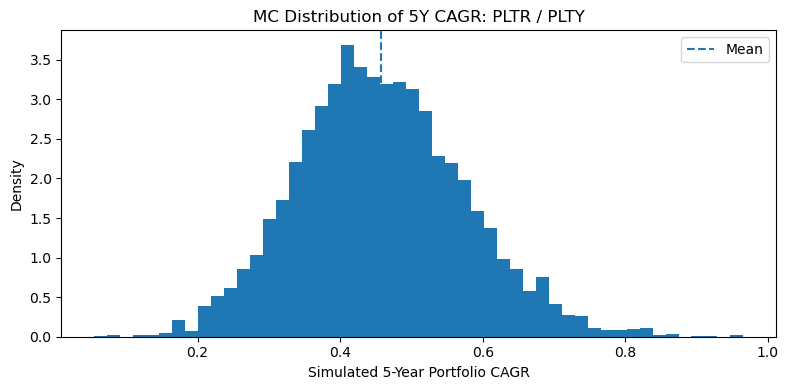

In [47]:
etf = "PLTY"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


NVDA / NVDU
Mean CAGR: 0.09807827398743049
P10: 0.06487239181213947
P50 (median): 0.09718521385655898
P90: 0.132419118077929


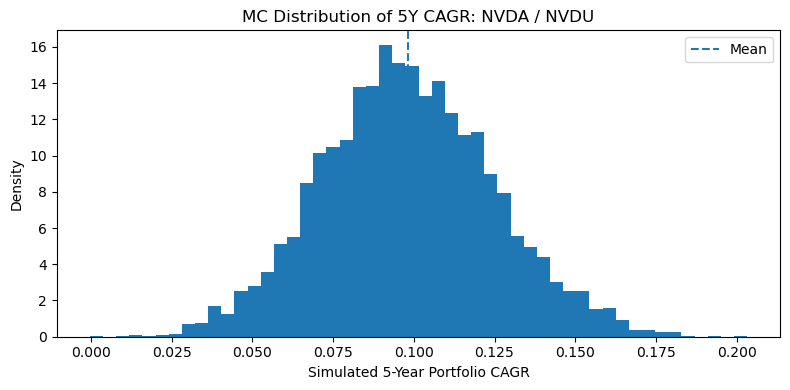

In [48]:
etf = "NVDU"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
# --- 1. Extract pairs ---

ym_df["Underlying"] = ym_df["Underlying"].str.replace(".", "-", regex=False)
pairs = list(zip(ym_df["Underlying"], ym_df["ETF"]))

# --- 2. Load all TR price series into a unified DataFrame ---
price_dict = {}

for und, etf in pairs:
    # Get total return series
    tr_und = get_total_return_series(und)
    tr_etf = get_total_return_series(etf)
    
    if not tr_und.empty:
        price_dict[f"{und}_TR"] = tr_und
    if not tr_etf.empty:
        price_dict[f"{etf}_TR"] = tr_etf

# Combine into one aligned DataFrame, KEEPING all dates
prices = pd.DataFrame(price_dict)   # <-- no dropna here
prices.tail()


,ABNB_TR,ABNY_TR,AI_TR,AIYY_TR,AMD_TR,AMDY_TR,AMZN_TR,AMZY_TR,AAPL_TR,APLY_TR,BABA_TR,BABO_TR,BRK-B_TR,BRKC_TR,COIN_TR,CONY_TR,CRCL_TR,CRCO_TR,CVNA_TR,CVNY_TR,DIS_TR,DISO_TR,DKNG_TR,DRAY_TR,META_TR,FBY_TR,GME_TR,GMEY_TR,GOOGL_TR,GOOY_TR,HIMS_TR,HIYY_TR,HOOD_TR,HOOY_TR,JPM_TR,JPMO_TR,MARA_TR,MARO_TR,MRNA_TR,MRNY_TR,MSFT_TR,MSFO_TR,MSTR_TR,MSTY_TR,NFLX_TR,NFLY_TR,NVDA_TR,NVDY_TR,PLTR_TR,PLTY_TR,PYPL_TR,PYPY_TR,RBLX_TR,RBLY_TR,RDDT_TR,RDYY_TR,SMCI_TR,SMCY_TR,SNOW_TR,SNOY_TR,TSLA_TR,TSLY_TR,TSM_TR,TSMY_TR,XOM_TR,XOMO_TR,XYZ_TR,XYZY_TR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-15 00:00:00-05:00,131.809998,87.916640,14.65,74.494087,207.580002,157.597158,222.539993,34.370931,357.642510,27.887066,158.139561,30.627482,506.380005,50.451937,250.419998,359.422579,75.459999,29.014660,447.920013,84.142674,179.495954,25.133765,35.590000,41.324132,651.996086,34.232645,32.880677,46.357059,310.567942,33.945548,36.250000,33.078254,115.260002,88.029052,1543.662176,29.295640,10.70,22.442923,29.920000,65.012763,775.670221,29.923330,162.080002,197.387205,93.769997,34.746291,192.261513,74.466193,183.250000,142.465560,60.881469,110.130731,86.959999,39.319176,218.500000,45.638176,31.370001,30.355820,215.279999,31.226202,475.309998,339.037346,574.660178,29.301835,2083.543464,20.452393,64.019997,122.508170
2025-12-16 00:00:00-05:00,132.009995,88.355700,14.49,74.140101,209.169998,159.438925,222.559998,34.397310,358.294880,28.011009,157.296652,30.560219,499.839996,50.114679,252.610001,363.042328,83.000000,32.255193,455.179993,85.897388,181.331698,25.552660,34.540001,40.540503,661.702888,34.725596,33.163490,47.199830,308.905378,33.852864,36.860001,33.806659,119.400002,91.102567,1522.100486,28.986307,10.69,22.594224,29.889999,65.259805,778.235000,30.079588,167.500000,203.975062,94.570000,35.092312,193.821077,75.043047,187.750000,145.845833,61.472843,112.053725,87.440002,39.877968,224.000000,47.053362,31.660000,30.669126,220.600006,32.080650,489.880005,346.704442,572.922667,29.398925,2029.048580,19.960834,64.550003,124.020882
2025-12-17 00:00:00-05:00,133.779999,88.580856,14.05,71.858868,198.110001,151.485808,221.270004,34.212662,354.680762,27.701152,154.978666,29.932424,504.269989,50.304246,244.190002,351.442744,79.199997,30.673713,446.230011,84.268014,179.723389,25.190316,34.049999,39.880068,653.999863,34.396963,34.279856,47.453479,298.980337,32.763827,34.970001,32.140525,115.800003,88.408726,1519.351121,28.804346,9.93,20.904701,30.510000,66.186208,777.793893,30.001459,160.380005,196.144208,94.790001,34.890467,186.426824,72.525877,177.289993,138.461233,60.320163,109.585007,85.910004,38.886645,227.339996,47.646627,29.840000,29.067787,216.289993,31.459231,467.260010,334.066370,553.130894,28.447439,2077.350894,20.320725,63.770000,121.777147
2025-12-18 00:00:00-05:00,133.990005,89.010532,13.77,70.619921,201.059998,153.775478,226.759995,34.980271,355.137429,27.827160,155.221013,30.179057,503.390015,50.235913,239.199997,345.601809,80.989998,31.328073,465.739990,86.413361,181.737834,25.393480,34.189999,39.993104,669.053452,34.906344,33.580265,46.915790,304.764053,33.394078,34.770000,32.081237,117.160004,89.267501,1509.800255,28.878950,9.69,20.470973,30.950001,66.013278,790.634086,30.444841,158.240005,193.888176,94.000000,34.746291,189.916734,73.663849,185.690002,144.038683,59.578438,108.173943,83.910004,38.001578,231.339996,47.997645,29.370001,28.663969,221.309998,32.062524,483.369995,342.997269,568.548902,28.917357,2061.957819,20.189058,64.389999,123.383950
2025-12-19 00:00:00-05:00,135.279999,90.162834,14.43,72.976582,213.429993,161.186855,227.350006,34.995134,357.068460,27.827160,157.834015,30.517641,495.529999,49.962888,245.119995,353.763004,86.169998,33.103171,452.029999,84.808146,180.730612,25.309046,34.209999,39.714946,663.334107,34.842979,33.550497,46.635357,309.499869,33.778856,35.540001,32.458433,121.349998,91.893550,1529.721924,28.970521,10.18,21.398008,33.799999,70.313952,793.803291,30.491723,164.820007,201.723001

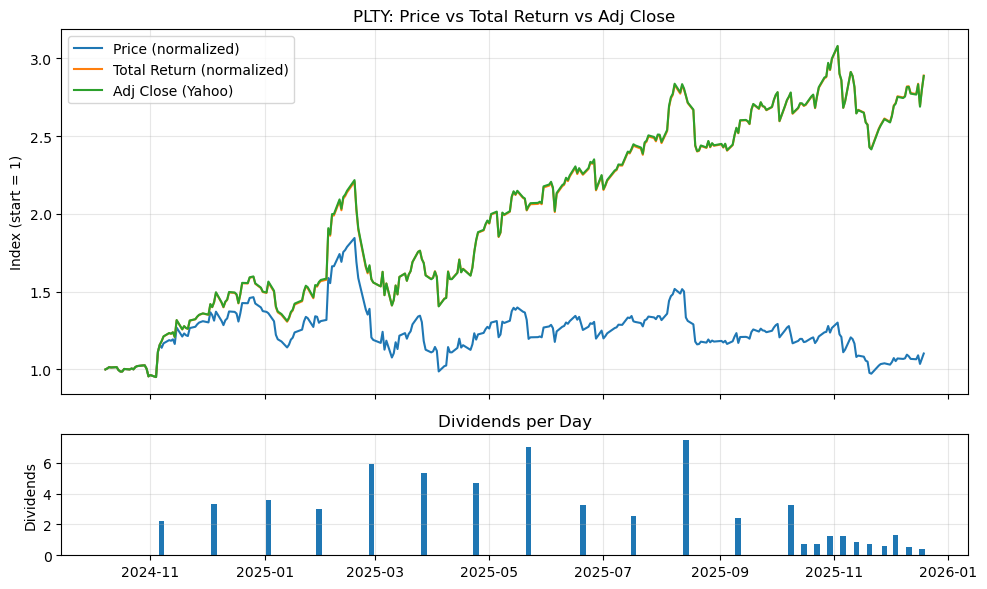

                               Close  Dividends
Date                                           
2024-11-07 00:00:00-05:00  58.577000      2.201
2024-12-05 00:00:00-05:00  67.547997      3.348
2025-01-03 00:00:00-05:00  69.989998      3.589
2025-01-30 00:00:00-05:00  66.860001      2.983
2025-02-27 00:00:00-05:00  62.000000      5.938
Price-only return: -0.01706551121768307
Total-return step: 0.019867735998939873


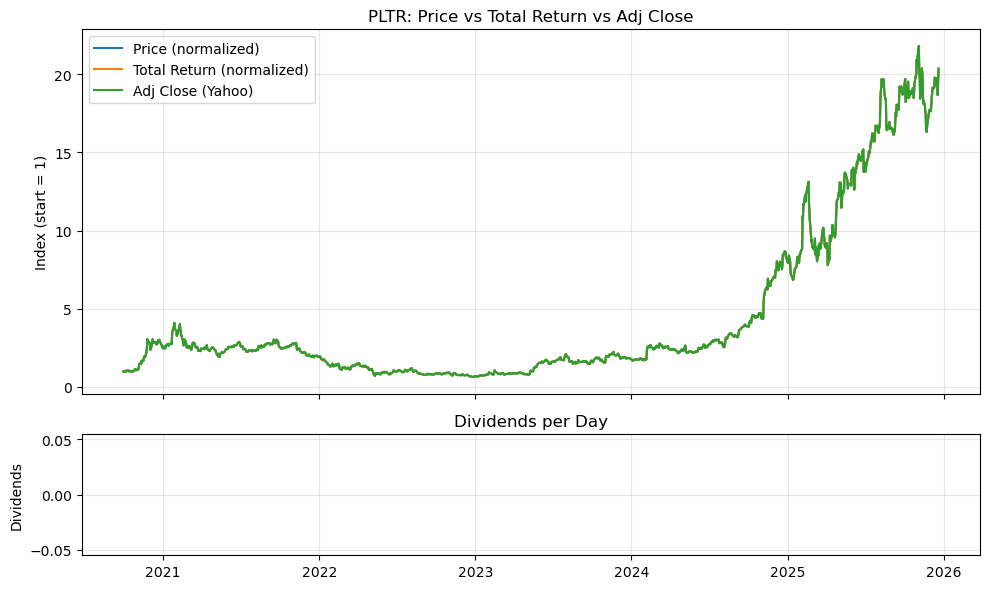

In [50]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for PLTY
df_plty = debug_tr_vs_adj("PLTY")

# Show rows where there is a non-zero dividend
div_days = df_plty[df_plty["Dividends"] != 0]
print(div_days[["Close", "Dividends"]].head())

# For a single ex-div day, compare price vs TR return
d = div_days.index[0]
prev = df_plty.loc[:d].iloc[-2]  # previous trading day
curr = df_plty.loc[d]

price_ret = curr["Close"] / prev["Close"] - 1
tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

print("Price-only return:", price_ret)
print("Total-return step:", tr_ret)

df_plty = debug_tr_vs_adj("PLTR")



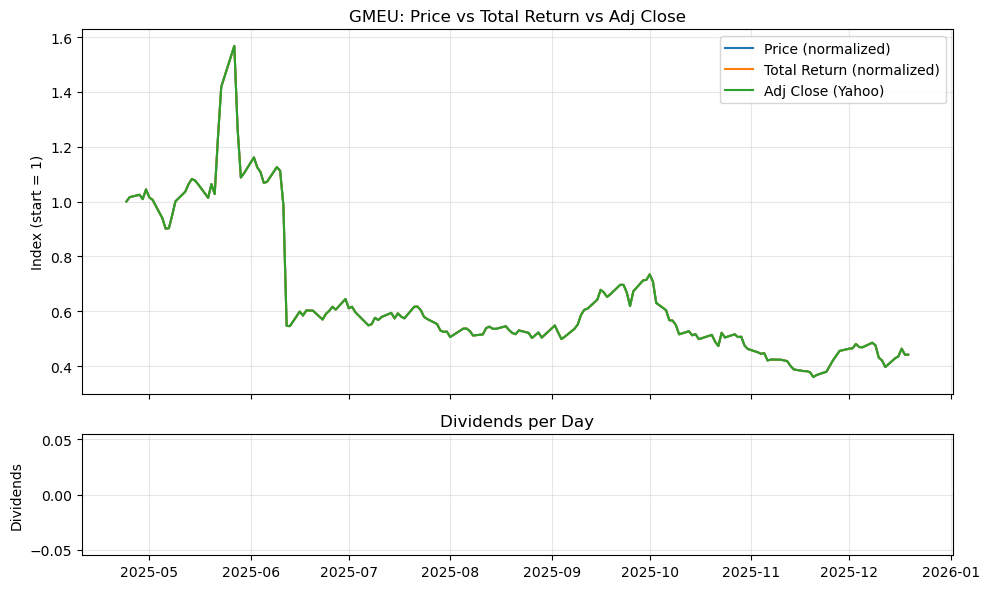

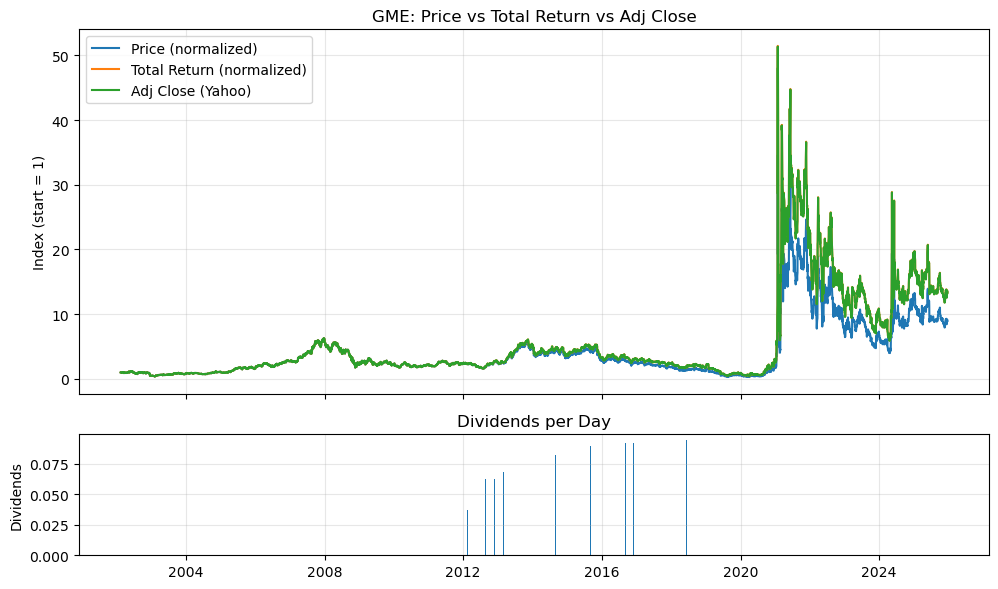

In [51]:
def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for GMEU
df_gmeu = debug_tr_vs_adj("GMEU")

# Show rows where there is a non-zero dividend
div_days = df_gmeu[df_gmeu["Dividends"] != 0]
# print(div_days[["Close", "Dividends"]].head())

# # For a single ex-div day, compare price vs TR return
# d = div_days.index[0]
# prev = df_gmeu.loc[:d].iloc[-2]  # previous trading day
# curr = df_gmeu.loc[d]

# price_ret = curr["Close"] / prev["Close"] - 1
# tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

# print("Price-only return:", price_ret)
# print("Total-return step:", tr_ret)

df_gme = debug_tr_vs_adj("GME")



In [52]:
trading_days = 252
default_borrow = 0.05   # 5% annual if not in map

# --- 1. Extract YM pairs only ---
ym_df["Underlying"] = ym_df["Underlying"].str.replace(".", "-", regex=False)
pairs = list(zip(ym_df["Underlying"], ym_df["ETF"]))

# --- 2. Load all TR price series into a unified DataFrame ---
price_dict = {}
for und, etf in pairs:
    tr_und = get_total_return_series(und)
    tr_etf = get_total_return_series(etf)
    if not tr_und.empty:
        price_dict[f"{und}_TR"] = tr_und
    if not tr_etf.empty:
        price_dict[f"{etf}_TR"] = tr_etf

prices = pd.DataFrame(price_dict)   # keep all dates
rets = prices.pct_change()          # keep NaNs

# --- 3. Build per-pair returns (with borrow) ---
port_rets_list = []

for und, etf in pairs:
    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col in rets.columns and etf_col in rets.columns:
        pair_df = rets[[und_col, etf_col]].dropna(how="any")
        if pair_df.empty:
            continue

        # Borrow rate for this ETF
        if "borrow_map" in globals() and borrow_map is not None:
            borrow_annual = borrow_map.get(
                etf,
                borrow_map.get("default", default_borrow)
            )
        else:
            borrow_annual = default_borrow

        borrow_daily = borrow_annual / trading_days

        w_long = 1.0
        w_short = -1.0

        ret_pair = (
            w_long * pair_df[und_col]
            + w_short * pair_df[etf_col]
            - abs(w_short) * borrow_daily
        )

        port_rets_list.append(ret_pair.rename(f"{und}/{etf}"))

if not port_rets_list:
    raise ValueError("No valid pairs with overlapping data found.")

# --- 4. Combine into equal-weight YM portfolio ---
port_panel = pd.concat(port_rets_list, axis=1)

# Drop the last day (avoids bad final data point)
port_panel = port_panel.iloc[:-1]

# Equal-weight across all YM pairs that have data on each date
port_ret = port_panel.mean(axis=1, skipna=True)
port_ret.name = "EqualWeight_YieldMax_LongUnderlying_ShortETF_withBorrow"
port_ret = port_ret.dropna()

# --- 5. Stats ---
T = len(port_ret)

cumulative = (1 + port_ret).prod()
cagr = cumulative ** (trading_days / T) - 1
vol = port_ret.std() * np.sqrt(trading_days)

cum_curve = (1 + port_ret).cumprod()
peak = np.maximum.accumulate(cum_curve)
dd = (cum_curve / peak - 1).min()

print("Portfolio CAGR (with borrow):", cagr)
print("Portfolio Vol:", vol)
print("Max Drawdown:", dd)


Portfolio CAGR (with borrow): 0.11910702580442556
Portfolio Vol: 0.1309842242965758
Max Drawdown: -0.11897977308491714


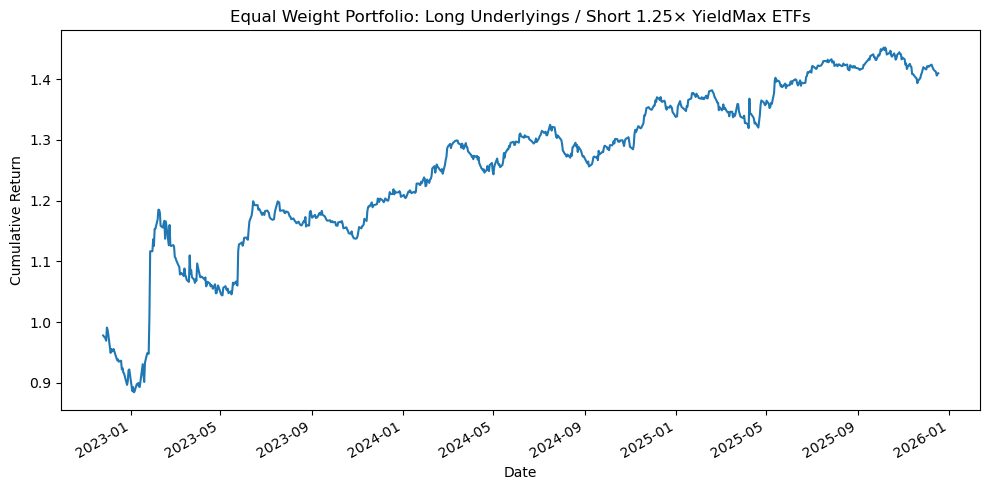

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
cum_curve.plot()
plt.title("Equal Weight Portfolio: Long Underlyings / Short 1.25× YieldMax ETFs")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [54]:
# ------------------------------
# CONFIG
# ------------------------------
trading_days   = 252
default_borrow = 0.05   # 5%
w_long         = 1.0
w_short        = -0.5

# ------------------------------
# 1. CLEAN DX DF + BUILD PAIRS
# ------------------------------
dx_df["Underlying"] = dx_df["Underlying"].str.replace(".", "-", regex=False)
pairs_dx = list(zip(dx_df["Underlying"], dx_df["ETF"]))

# ------------------------------
# 2. LOAD ALL TR SERIES FIRST
# ------------------------------
price_dict = {}

for und, etf in pairs_dx:
    tr_und = get_total_return_series(und)
    tr_etf = get_total_return_series(etf)

    if not tr_und.empty:
        price_dict[f"{und}_TR"] = tr_und
    if not tr_etf.empty:
        price_dict[f"{etf}_TR"] = tr_etf

prices = pd.DataFrame(price_dict)
rets   = prices.pct_change()    # <-- used for *both* stats and portfolio

# ------------------------------
# 3. CALCULATE PER-PAIR CAGRs
# ------------------------------
pair_stats = []

for und, etf in pairs_dx:
    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col not in rets.columns or etf_col not in rets.columns:
        continue

    pair_df = rets[[und_col, etf_col]].dropna()
    if pair_df.empty:
        continue

    # Borrow
    if "borrow_map" in globals() and borrow_map is not None:
        borrow_annual = borrow_map.get(etf, borrow_map.get("default", default_borrow))
    else:
        borrow_annual = default_borrow

    borrow_daily = borrow_annual / trading_days

    # Return series
    ret_pair = (
        w_long  * pair_df[und_col]
        + w_short * pair_df[etf_col]
        - abs(w_short) * borrow_daily
    ).dropna()

    if ret_pair.empty:
        continue

    T = len(ret_pair)
    cumulative = (1 + ret_pair).prod()
    cagr = cumulative ** (trading_days / T) - 1

    pair_stats.append({
        "Underlying": und,
        "ETF": etf,
        "CAGR": cagr,
        "BorrowAnnual": borrow_annual
    })

dx_stats = pd.DataFrame(pair_stats)

# If no rows, fail early
if dx_stats.empty:
    raise ValueError("dx_stats is empty — no valid DX tickers matched TR data.")

# ------------------------------
# 4. EXCLUDE BAD PAIRS (CAGR<0 and borrow>10%)
# ------------------------------
bad_mask = (dx_stats["CAGR"] < 0) & (dx_stats["BorrowAnnual"] > 0.10)
bad_etfs = set(dx_stats.loc[bad_mask, "ETF"])

print("Excluding these DX ETFs:", bad_etfs)

dx_df_filtered = dx_df[~dx_df["ETF"].isin(bad_etfs)].copy()
pairs_dx_filtered = list(zip(dx_df_filtered["Underlying"], dx_df_filtered["ETF"]))

# ------------------------------
# 5. BUILD PORTFOLIO RETURN STREAMS
# ------------------------------
port_rets_list = []
used_pairs_info = []   # <-- NEW: track which pairs and their date ranges

for und, etf in pairs_dx_filtered:
    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col not in rets.columns or etf_col not in rets.columns:
        continue

    pair_df = rets[[und_col, etf_col]].dropna()
    if pair_df.empty:
        continue

    if "borrow_map" in globals() and borrow_map is not None:
        borrow_annual = borrow_map.get(etf, borrow_map.get("default", default_borrow))
    else:
        borrow_annual = default_borrow

    borrow_daily = borrow_annual / trading_days

    ret_pair = (
        w_long * pair_df[und_col]
        + w_short * pair_df[etf_col]
        - abs(w_short) * borrow_daily
    ).dropna()

    if ret_pair.empty:
        continue

    pair_name = f"{und}/{etf}"
    port_rets_list.append(ret_pair.rename(pair_name))

    # --- NEW: record metadata for this pair
    used_pairs_info.append({
        "Underlying": und,
        "ETF": etf,
        "Pair": pair_name,
        "StartDate": ret_pair.index.min(),
        "EndDate": ret_pair.index.max(),
        "NumTradingDays": len(ret_pair)
    })

# If empty, fail
if not port_rets_list:
    raise ValueError("No valid DX pairs remained after filtering.")

# Turn metadata into a DataFrame and print
used_pairs_df = pd.DataFrame(used_pairs_info)
used_pairs_df = used_pairs_df.sort_values(["StartDate", "ETF"])

print("\nPairs actually used in the DX portfolio and their date ranges:\n")
print(used_pairs_df.to_string(index=False))

# ------------------------------
# 6. BUILD PORTFOLIO PANEL
# ------------------------------
port_panel = pd.concat(port_rets_list, axis=1)
port_panel = port_panel.iloc[:-1]     # drop last day (cleaner)
port_ret = port_panel.mean(axis=1).dropna()
port_ret.name = "EqualWeight_2x_LongUnderlying_ShortETF_withBorrow"

# ------------------------------
# 7. PORTFOLIO METRICS
# ------------------------------
T = len(port_ret)
cumulative = (1 + port_ret).prod()
cagr = cumulative ** (trading_days / T) - 1
vol = port_ret.std() * np.sqrt(trading_days)

cum_curve = (1 + port_ret).cumprod()
peak = np.maximum.accumulate(cum_curve)
dd = (cum_curve / peak - 1).min()

print("\nPortfolio CAGR (with borrow):", cagr)
print("Portfolio Vol:", vol)
print("Max Drawdown:", dd)


C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\3216435960.py:30: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets   = prices.pct_change()    # <-- used for *both* stats and portfolio


Excluding these DX ETFs: {'XYZG', 'RTXG', 'FUTG', 'HOOG', 'GLGG', 'MPG', 'FIGG', 'BLSG', 'TSMX', 'GMEU', 'COTG', 'GRAG', 'NUG', 'SPOG', 'LULG', 'COIO', 'SHPU', 'AVL', 'ARMG', 'MSOO', 'PYPG', 'AALG', 'CRCG', 'BOEU', 'ADBG', 'OSCG', 'NEMG', 'NBIG', 'NETG'}

Pairs actually used in the DX portfolio and their date ranges:

Underlying  ETF       Pair                 StartDate                   EndDate  NumTradingDays
      AAPL AAPU  AAPL/AAPU 2022-08-10 00:00:00-04:00 2025-12-19 00:00:00-05:00             845
      TSLA TSLL  TSLA/TSLL 2022-08-10 00:00:00-04:00 2025-12-19 00:00:00-05:00             845
      AMZN AMZU  AMZN/AMZU 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
     GOOGL GGLL GOOGL/GGLL 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
      MSFT MSFU  MSFT/MSFU 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
      NVDA NVDU  NVDA/NVDU 2023-09-14 00:00:00-04:00 2025-12-19 00:00:00-05:00             570
      IBIT BITX

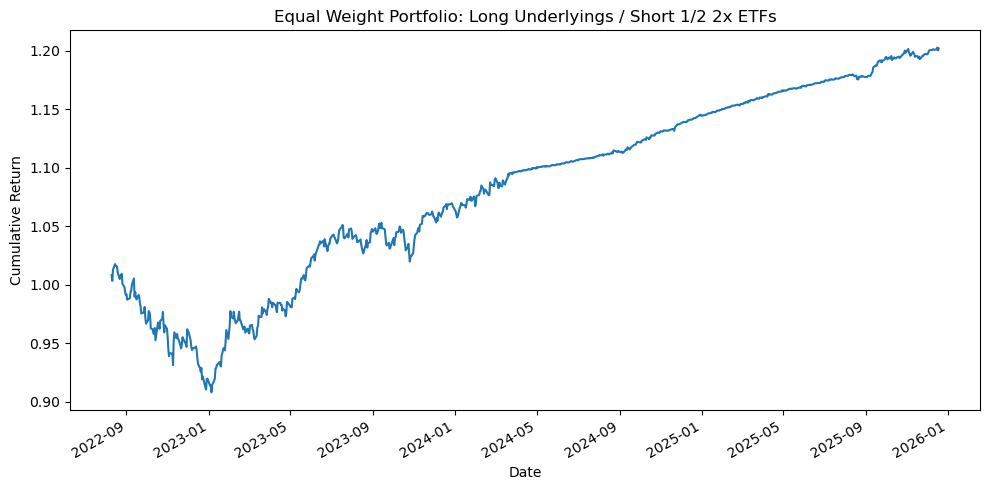

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
cum_curve.plot()
plt.title("Equal Weight Portfolio: Long Underlyings / Short 1/2 2x ETFs")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [56]:
#Test different rebalance frequencies: daily, weekly, biweekly, monthly and see how it impacts results
#Start create a systematic trading strategy on interactive brokers with a simple algorithm

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# CONFIG
# ------------------------------
trading_days   = 252
default_borrow = 0.05   # 5% annual if not in map

# Hedge ratios:
CC_SHORT_RATIO   = -1.0   # long 1 underlying : short 1 CC ETF (YieldMax 1x)
LEV2_SHORT_RATIO = -0.5   # long 1 underlying : short 0.5 of a 2x ETF

# ------------------------------
# 0. TAG SOURCES & BUILD ALL_DF
# ------------------------------
dx_df = dx_df.copy()
ym_df = ym_df.copy()

dx_df["LevType"] = "2x"
ym_df["LevType"] = "CC"

# Combine dx (2x) and ym (covered call) – EXCLUDING cc_df entirely
all_df = pd.concat([dx_df, ym_df], ignore_index=True)

print("Universe of ETFs (raw):")
print(all_df[["Underlying", "ETF", "LevType"]])

# Clean underlying / ETF tickers
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""].copy()
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)

all_df["ETF"]        = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

print("\nUniverse after cleaning:")
print(all_df[["Underlying", "ETF", "LevType"]])

# ------------------------------
# 1. MERGE IN HISTORICAL CAGRs (results_df_mc)
# ------------------------------
hist_cols_needed = ["Underlying", "ETF", "cagr_port_hist"]
missing_cols = [c for c in hist_cols_needed if c not in results_df_mc.columns]
if missing_cols:
    raise ValueError(f"results_df_mc missing columns: {missing_cols}")

hist_df = results_df_mc.copy()
hist_df["ETF"]        = hist_df["ETF"].str.replace(".", "-", regex=False)
hist_df["Underlying"] = hist_df["Underlying"].str.replace(".", "-", regex=False)

all_full = all_df.merge(
    hist_df[hist_cols_needed],
    on=["Underlying", "ETF"],
    how="left",
    validate="1:1"
)

# Drop rows with no historical CAGR (or change if you want to keep them)
all_full = all_full.dropna(subset=["cagr_port_hist"]).copy()

# ------------------------------
# 2. ATTACH CURRENT BORROW RATES
# ------------------------------
def get_borrow_current(etf):
    if "borrow_map" in globals() and borrow_map is not None:
        if etf in borrow_map:
            return borrow_map[etf]
        if "default" in borrow_map:
            return borrow_map["default"]
    return default_borrow

all_full["borrow_current"] = all_full["ETF"].apply(get_borrow_current)

# ------------------------------
# 3. FILTER: EXCLUDE (CAGR<0 AND borrow>10%)
# ------------------------------
bad_mask = (all_full["cagr_port_hist"] < 0) & (all_full["borrow_current"] > 0.10)
bad_etfs = set(all_full.loc[bad_mask, "ETF"])

print("\nExcluding ETFs (neg hist CAGR AND borrow >10%):")
print(bad_etfs)

all_good = all_full[~all_full["ETF"].isin(bad_etfs)].copy()
if all_good.empty:
    raise ValueError("No ETFs left after filtering CAGR/borrow condition.")

print("\nETFs used in portfolio after filter:")
print(all_good[["Underlying", "ETF", "LevType", "cagr_port_hist", "borrow_current"]])

# ------------------------------
# 4. BUILD PER-PAIR WEIGHTS (1 long underlying per ETF)
# ------------------------------
def short_ratio_for_row(row):
    if row["LevType"] == "2x":
        return LEV2_SHORT_RATIO
    else:  # YieldMax / CC
        return CC_SHORT_RATIO

all_good["w_etf_per_pair"]   = all_good.apply(short_ratio_for_row, axis=1)
all_good["w_under_per_pair"] = 1.0  # one long underlying per ETF

# Aggregate: e.g. MSTR with MSTY & MSTX → +2 MSTR, -1 MSTY, -0.5 MSTX
w_under_by_und = all_good.groupby("Underlying")["w_under_per_pair"].sum()
w_etf_by_etf   = all_good.groupby("ETF")["w_etf_per_pair"].sum()

print("\nNet underlying weights:")
print(w_under_by_und)

print("\nNet ETF weights:")
print(w_etf_by_etf)

# Borrow daily map per ETF
borrow_daily_map = (
    all_good
    .drop_duplicates(subset=["ETF"])
    .set_index("ETF")["borrow_current"] / trading_days
)

# ------------------------------
# 5. LOAD TOTAL RETURN SERIES FOR ALL SYMBOLS
# ------------------------------
all_symbols = sorted(set(w_under_by_und.index) | set(w_etf_by_etf.index))

price_dict = {}
for sym in all_symbols:
    tr = get_total_return_series(sym)
    if tr.empty:
        print(f"WARNING: no TR data for {sym}, zeroing its weight.")
        if sym in w_under_by_und.index:
            w_under_by_und.loc[sym] = 0.0
        if sym in w_etf_by_etf.index:
            w_etf_by_etf.loc[sym] = 0.0
        continue
    price_dict[f"{sym}_TR"] = tr

prices = pd.DataFrame(price_dict)
rets   = prices.pct_change()

# Drop zero-weight symbols
w_under_by_und = w_under_by_und[w_under_by_und != 0]
w_etf_by_etf   = w_etf_by_etf[w_etf_by_etf != 0]

# ------------------------------
# 5b. SET GLOBAL BACKTEST START DATE
# ------------------------------
# Start backtest when the FIRST ETF (dx_df or ym_df) starts having data.
etf_tr_cols = [f"{etf}_TR" for etf in w_etf_by_etf.index if f"{etf}_TR" in rets.columns]

start_dates = []
for col in etf_tr_cols:
    first_idx = rets[col].first_valid_index()
    if first_idx is not None:
        start_dates.append(first_idx)

if not start_dates:
    raise ValueError("No valid ETF return series to determine backtest start.")

backtest_start = min(start_dates)
print("\nGlobal backtest start date (first ETF data):", backtest_start)

# Restrict rets (and thus portfolio) to dates >= backtest_start
rets = rets.loc[backtest_start:].copy()

# ------------------------------
# 6. COMPONENT DATE RANGES / METADATA
# ------------------------------
component_info = []
all_good_unique = all_good.drop_duplicates(subset=["ETF"])

for _, row in all_good_unique.iterrows():
    und = row["Underlying"]
    etf = row["ETF"]
    lev = row["LevType"]
    borrow_annual = row["borrow_current"]

    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col not in rets.columns or etf_col not in rets.columns:
        continue

    pair_df = rets[[und_col, etf_col]].dropna()
    if pair_df.empty:
        continue

    start_date = pair_df.index.min()
    end_date   = pair_df.index.max()
    n_days     = len(pair_df)

    w_u = w_under_by_und.get(und, 0.0)
    w_e = w_etf_by_etf.get(etf, 0.0)

    component_info.append({
        "Underlying": und,
        "ETF": etf,
        "LevType": lev,
        "w_under_total": w_u,
        "w_etf_total": w_e,
        "BorrowAnnual": borrow_annual,
        "StartDate": start_date,
        "EndDate": end_date,
        "NumTradingDays": n_days,
    })

components_df = pd.DataFrame(component_info)
components_df = components_df.sort_values(["StartDate", "ETF"])

print("\nComponents used in the global portfolio and their date ranges:\n")
if not components_df.empty:
    print(components_df.to_string(index=False))
else:
    print("No overlapping data for any Underlying/ETF pair.")

# ------------------------------
# 7. BUILD DAILY PORTFOLIO RETURNS (RAW, NOT NORMALIZED)
# ------------------------------
port_ret = pd.Series(0.0, index=rets.index)

# Underlying leg
for und, w_u in w_under_by_und.items():
    col = f"{und}_TR"
    if col not in rets.columns:
        print(f"Missing return series for underlying {und}, skipping.")
        continue
    port_ret = port_ret.add(w_u * rets[col], fill_value=0.0)

# ETF legs (short) + borrow cost
for etf, w_e in w_etf_by_etf.items():
    col = f"{etf}_TR"
    if col not in rets.columns:
        print(f"Missing return series for ETF {etf}, skipping.")
        continue

    port_ret = port_ret.add(w_e * rets[col], fill_value=0.0)

    b_daily = borrow_daily_map.get(etf, default_borrow / trading_days)
    port_ret = port_ret.add(-abs(w_e) * b_daily, fill_value=0.0)

port_ret = port_ret.dropna()
port_ret.name = "Global_LongUnderlyings_ShortYM_2x_withBorrow_RAW"

Universe of ETFs (raw):
    Underlying   ETF LevType
0         AAPL  AAPU      2x
1          AMD  AMUU      2x
2         AMZN  AMZU      2x
3         AVGO   AVL      2x
4         IBIT  BITX      2x
5           BA  BOEU      2x
6        BRK-B  BRKU      2x
7         BULL  BULU      2x
8         CSCO  CSCL      2x
9          LLY  ELIL      2x
10        ETHA  ETHU      2x
11           F  FRDU      2x
12       GOOGL  GGLL      2x
13         GME  GMEU      2x
14         LMT  LMTL      2x
15        META  METU      2x
16          MU   MUU      2x
17        MSFT  MSFU      2x
18        MSTR  MSTX      2x
19        NVDA  NVDU      2x
20        NFLX  NFXL      2x
21        PLTR  PLTU      2x
22        PANW  PALU      2x
23        QCOM  QCMU      2x
24        SHOP  SHPU      2x
25         TSM  TSMX      2x
26        TSLA  TSLL      2x
27         XOM  XOMX      2x
28         XRP  XXRP      2x
29         AAL  AALG      2x
30        ABNB  ABNG      2x
31        ADBE  ADBG      2x
32         ARM  ARM

C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\2018404302.py:139: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets   = prices.pct_change()



Global backtest start date (first ETF data): 2022-08-10 00:00:00-04:00

Components used in the global portfolio and their date ranges:

Underlying  ETF LevType  w_under_total  w_etf_total  BorrowAnnual                 StartDate                   EndDate  NumTradingDays
      AAPL AAPU      2x            2.0         -0.5      0.047780 2022-08-10 00:00:00-04:00 2025-12-19 00:00:00-05:00             845
      TSLA TSLL      2x            3.0         -0.5      0.079644 2022-08-10 00:00:00-04:00 2025-12-19 00:00:00-05:00             845
      AMZN AMZU      2x            2.0         -0.5      0.077638 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
     GOOGL GGLL      2x            2.0         -0.5      0.035128 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
      MSFT MSFU      2x            2.0         -0.5      0.048332 2022-09-08 00:00:00-04:00 2025-12-19 00:00:00-05:00             825
      TSLA TSLY      CC            3.0         -1.0      0.

In [58]:

# ------------------------------
# 8. DIAGNOSTICS: ARE WE BLOWING UP?
# ------------------------------
print("\nWeight summary:")
print("Sum underlying weights:", w_under_by_und.sum())
print("Sum ETF weights:", w_etf_by_etf.sum())
print("Total gross |weights|:",
      np.sum(np.abs(w_under_by_und)) + np.sum(np.abs(w_etf_by_etf)))

print("\nPortfolio daily returns summary (RAW, unscaled):")
print(port_ret.describe())


# ------------------------------
# 9. NORMALIZE LEVERAGE (EFFECTIVE 1x GROSS)
# ------------------------------
gross_notional = np.sum(np.abs(w_under_by_und)) + np.sum(np.abs(w_etf_by_etf))
if gross_notional > 0:
    port_ret_norm = port_ret / gross_notional
else:
    port_ret_norm = port_ret.copy()

port_ret_norm.name = "Global_LongUnderlyings_ShortYM_2x_withBorrow_NORM"

print("\nNormalized portfolio daily returns summary (dividing by gross notional):")
print(port_ret_norm.describe())

# ------------------------------
# 10. PORTFOLIO METRICS (NORMALIZED)
# ------------------------------
T = len(port_ret_norm)
if T == 0:
    raise ValueError("No overlapping data for the portfolio.")

cumulative = (1 + port_ret_norm).prod()
cagr = cumulative ** (trading_days / T) - 1
vol  = port_ret_norm.std() * np.sqrt(trading_days)

cum_curve = (1 + port_ret_norm).cumprod()
peak      = np.maximum.accumulate(cum_curve)
dd        = (cum_curve / peak - 1).min()

print("\n=== Global Portfolio Metrics (Normalized) ===")
print("Trading days:", T)
print("Portfolio CAGR (with borrow):", cagr)
print("Portfolio Vol:", vol)
print("Max Drawdown:", dd)


Weight summary:
Sum underlying weights: 79.0
Sum ETF weights: -54.5
Total gross |weights|: 133.5

Portfolio daily returns summary (RAW, unscaled):
count    845.000000
mean       0.099039
std        1.089490
min       -3.891310
25%       -0.497682
50%        0.087513
75%        0.648384
max        7.361401
Name: Global_LongUnderlyings_ShortYM_2x_withBorrow_RAW, dtype: float64

Normalized portfolio daily returns summary (dividing by gross notional):
count    845.000000
mean       0.000742
std        0.008161
min       -0.029148
25%       -0.003728
50%        0.000656
75%        0.004857
max        0.055142
Name: Global_LongUnderlyings_ShortYM_2x_withBorrow_NORM, dtype: float64

=== Global Portfolio Metrics (Normalized) ===
Trading days: 845
Portfolio CAGR (with borrow): 0.1954700697283771
Portfolio Vol: 0.12955148053444185
Max Drawdown: -0.18354940197717995


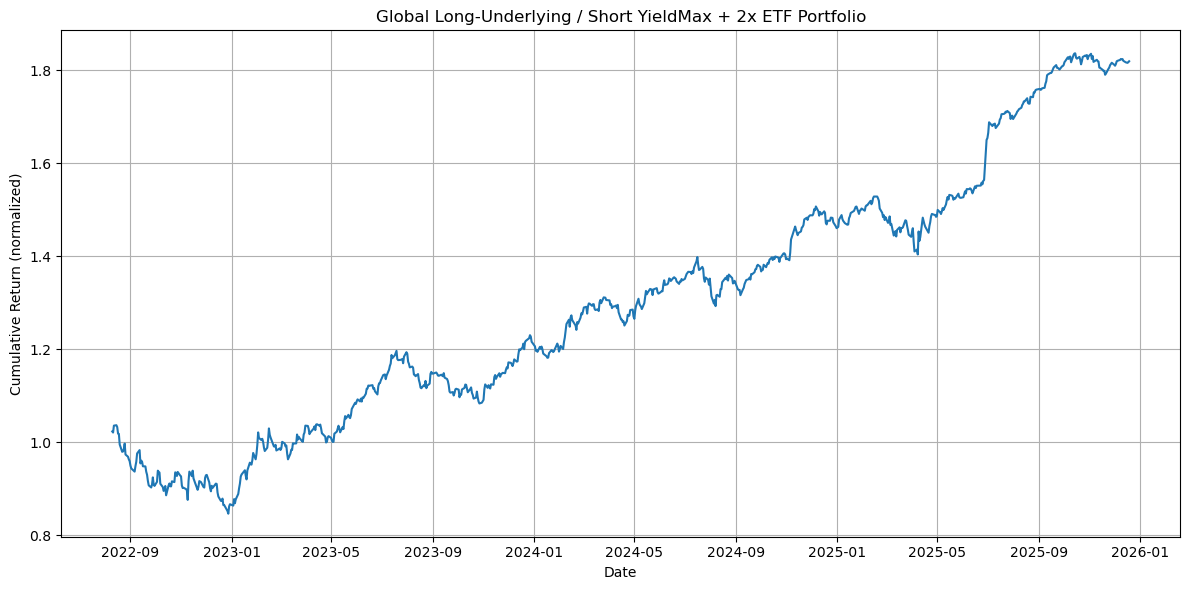

In [59]:
# ------------------------------
# 11. PLOT EQUITY CURVE (NORMALIZED)
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(cum_curve.index, cum_curve.values)
plt.xlabel("Date")
plt.ylabel("Cumulative Return (normalized)")
plt.title("Global Long-Underlying / Short YieldMax + 2x ETF Portfolio")
plt.grid(True)
plt.tight_layout()
plt.show()


CC ETFs: {'CVNY', 'XYZY', 'DISO', 'XOMO', 'APLY', 'AIYY', 'SNOY', 'MARO', 'ABNY', 'FBY', 'RDYY', 'MSFO', 'MSTY', 'NVDY', 'BRKC', 'GMEY', 'PYPY', 'TSLY', 'CONY', 'NFLY', 'DRAY', 'AMDY', 'GOOY', 'HOOY', 'PLTY', 'TSMY', 'RBLY', 'AMZY', 'SMCY', 'HIYY', 'CRCO', 'MRNY', 'JPMO', 'BABO'}
2x ETFs: {'KLAG', 'FIGG', 'BLSG', 'ETHU', 'PLTU', 'BRKU', 'SPOG', 'COIO', 'TSLL', 'UPSG', 'AVL', 'XXRP', 'SNAG', 'XOMX', 'ABNG', 'NETG', 'MSFU', 'CRMG', 'OKTG', 'HOOG', 'SATG', 'DUOG', 'IREG', 'LACG', 'BEG', 'GMEU', 'COTG', 'BIDG', 'VALG', 'AAPU', 'COIG', 'NVDO', 'MUU', 'CIFG', 'UNHG', 'NFXL', 'ADBG', 'NEMG', 'AMUU', 'FUTG', 'BAIG', 'GLGG', 'MPG', 'QCMU', 'CMGG', 'GRAG', 'NUG', 'LMTL', 'PLOO', 'BULU', 'PBRG', 'LULG', 'SHPU', 'ASMG', 'FRDU', 'MSOO', 'GEMG', 'SBU', 'NVDU', 'ELIL', 'OSCG', 'NBIG', 'PYPG', 'XYZG', 'PALU', 'RTXG', 'BITX', 'AMZU', 'CNCG', 'TSMX', 'TERG', 'CRWG', 'CSCL', 'MSTX', 'BMNG', 'METU', 'GGLL', 'TSLO', 'GEVG', 'ARMG', 'AALG', 'CRCG', 'OPEG', 'NIOG', 'BOEU'}

=== Portfolio Comparison ===
     

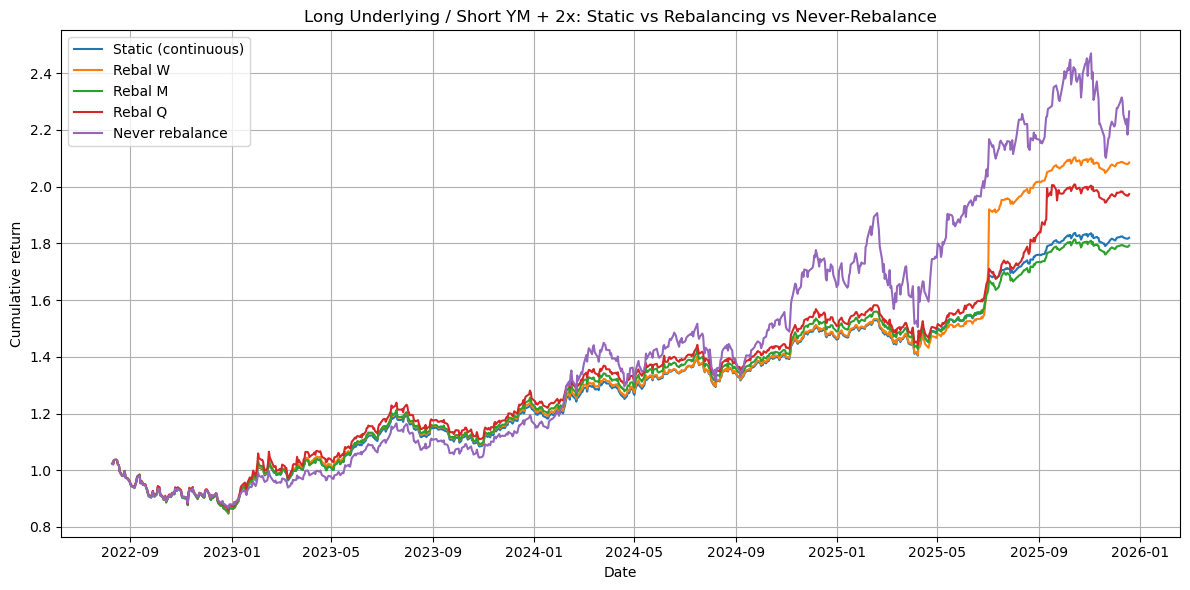

In [152]:
cc_etfs = set(ym_df["ETF"].str.replace(".", "-", regex=False))

# Levered 2× ETFs = DX universe
lev2_etfs = set(dx_df["ETF"].str.replace(".", "-", regex=False))

print("CC ETFs:", cc_etfs)
print("2x ETFs:", lev2_etfs)

trading_days   = 252
default_borrow = 0.05   # 5% annual if no specific borrow is known


# ---------- Helpers ----------

def perf_stats(ret, label):
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0,
                "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1
    vol  = ret.std() * np.sqrt(trading_days)
    curve = (1 + ret).cumprod()
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T,
            "CAGR": cagr, "Vol": vol, "MaxDD": dd}


# ---------- 1) Static / Continuous (constant weights every day) ----------

def compute_static_continuous(rets, w_under, w_etf, borrow_daily_map):
    """
    Constant normalized weights every day (what we called 'continuous / daily').
    """
    w_under = w_under.copy()
    w_etf   = w_etf.copy()

    combined_w = pd.concat([w_under, w_etf])
    combined_w = combined_w[combined_w != 0]

    gross0 = combined_w.abs().sum()
    w_const = combined_w / gross0          # 1x gross

    # build returns submatrix
    sym_to_col = {sym: f"{sym}_TR" for sym in w_const.index
                  if f"{sym}_TR" in rets.columns}
    w_const = w_const[w_const.index.isin(sym_to_col.keys())]

    rets_local = rets[[sym_to_col[sym] for sym in w_const.index]].dropna(how="all")
    idx = rets_local.index

    # daily borrow costs for ETFs
    borrow_daily = {
        sym: borrow_daily_map.get(sym, default_borrow / trading_days)
        if sym in w_etf.index else 0.0
        for sym in w_const.index
    }

    port_ret = pd.Series(index=idx, dtype=float)

    for t in idx:
        row = rets_local.loc[t]
        r_p = 0.0
        for sym, col in sym_to_col.items():
            r = row[col]
            if pd.isna(r):
                r = 0.0
            r_p += w_const[sym] * r

        # borrow drag
        r_p -= sum(abs(w_const[sym]) * borrow_daily[sym] for sym in w_const.index)
        port_ret.loc[t] = r_p

    return port_ret.dropna()



# --- NEW: Pair-aware rebalancing / never-rebalance helpers ---
# Enforces correct start dates per (Underlying, ETF) pair: pairs contribute only after BOTH legs have valid data.

def _normalize_sym(s: str) -> str:
    return str(s).replace(".", "-")

def simulate_rebalancing_with_weights(
    rets,
    w_under,
    w_etf,
    borrow_daily_map,
    freq="M",
    sym_start: dict[str, pd.Timestamp] | None = None,
    default_borrow=0.05,
    trading_days=252,
):
    """
    Same as simulate_rebalancing_with_weights, but:
      - sets weights to 0 for any symbol whose pair-start date is after current date
      - on rebalance dates (and on any activation date), re-targets weights over ACTIVE symbols only, normalized to 1× gross
    """
    # tz-naive
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    # normalize symbol indexes to match TR columns convention
    w_under = w_under.copy()
    w_under.index = w_under.index.map(_normalize_sym)
    w_etf = w_etf.copy()
    w_etf.index = w_etf.index.map(_normalize_sym)

    combined_w = pd.concat([w_under, w_etf])
    combined_w = combined_w[combined_w != 0]
    if combined_w.empty:
        raise ValueError("No non-zero weights.")

    # map to TR columns
    sym_to_col = {sym: f"{sym}_TR" for sym in combined_w.index if f"{sym}_TR" in rets_local.columns}
    if not sym_to_col:
        raise ValueError("No matching TR columns for weights.")

    # returns matrix
    cols = [sym_to_col[sym] for sym in sym_to_col.keys()]
    rets_mat = rets_local[cols].copy().dropna(how="all")
    idx = rets_mat.index

    # daily borrow
    default_daily = default_borrow / trading_days
    borrow_daily = {
        sym: borrow_daily_map.get(sym, default_daily) if sym in w_etf.index else 0.0
        for sym in sym_to_col.keys()
    }

    # rebalance days
    if freq == "D":
        rebal_days = set(idx)
    else:
        periods = idx.to_period(freq)
        rebal_dates = (
            pd.Series(idx, index=idx)
            .groupby(periods)
            .apply(lambda s: s.iloc[-1])
            .values
        )
        rebal_days = set(rebal_dates)
        rebal_days.add(idx[0])

    # activation days (first day a symbol becomes tradable) -> treat as rebalance so the universe can expand
    sym_start = sym_start or {}
    activation_days = set()
    for sym, d0 in sym_start.items():
        if d0 in idx:
            activation_days.add(d0)

    # helper: build target weights over active symbols on date t
    def _target_weights_on(t):
        w = combined_w.copy()

        if sym_start:
            active_syms = [s for s in w.index if (s not in sym_start) or (t >= sym_start[s])]
            w = w.loc[active_syms]
        else:
            active_syms = list(w.index)

        # keep only symbols with TR column
        active_syms = [s for s in active_syms if s in sym_to_col]
        w = w.loc[active_syms]

        if w.empty:
            return pd.Series(dtype=float)

        gross = w.abs().sum()
        if gross == 0:
            return pd.Series(dtype=float)

        return (w / gross)

    # initialize
    port_ret_rb  = pd.Series(index=idx, dtype=float)
    weights_df   = pd.DataFrame(index=idx, columns=list(sym_to_col.keys()), dtype=float)
    gross_series = pd.Series(index=idx, dtype=float)

    # start weights on first day (active-only)
    w_prev_full = pd.Series(0.0, index=list(sym_to_col.keys()))
    w_prev = _target_weights_on(idx[0])
    w_prev_full.loc[w_prev.index] = w_prev

    for t in idx:
        # rebuild target weights when rebalancing or activating
        do_rebal = (t in rebal_days) or (t in activation_days)

        # compute returns for all symbols, but inactive symbols contribute 0 weight
        row = rets_mat.loc[t]

        r_vec = {}
        for sym in sym_to_col.keys():
            col = sym_to_col[sym]
            r = row[col]
            r_vec[sym] = 0.0 if pd.isna(r) else float(r)

        # borrow drag only on active weights
        borrow_cost_t = 0.0
        for sym, w in w_prev_full.items():
            if sym in w_etf.index:
                borrow_cost_t += abs(w) * borrow_daily.get(sym, default_daily)

        # record weights & gross
        weights_df.loc[t, :] = w_prev_full
        gross_series.loc[t]  = np.abs(w_prev_full).sum()

        # portfolio return
        r_p = sum(w_prev_full[sym] * r_vec[sym] for sym in sym_to_col.keys()) - borrow_cost_t
        port_ret_rb.loc[t] = r_p

        denom = 1.0 + r_p
        if denom == 0:
            break

        # drift weights (only for symbols that currently have nonzero weight)
        w_pre_full = {}
        for sym in sym_to_col.keys():
            w_pre_full[sym] = w_prev_full[sym] * (1 + r_vec[sym]) / denom
        w_pre_full = pd.Series(w_pre_full)

        if do_rebal:
            w_tgt = _target_weights_on(t)
            w_next = pd.Series(0.0, index=list(sym_to_col.keys()))
            w_next.loc[w_tgt.index] = w_tgt
            w_prev_full = w_next
        else:
            w_prev_full = w_pre_full

    return port_ret_rb.dropna(), weights_df.dropna(how="all"), gross_series.dropna()


def compute_never_rebalance(
    rets,
    w_under,
    w_etf,
    borrow_daily_map,
    sym_start: dict[str, pd.Timestamp] | None = None,
    default_borrow=0.05,
    trading_days=252,
):
    """
    Never-rebalance, but pair-aware:
      - weights are 0 until the pair is active
      - when a pair becomes active, its target weight is introduced (universe expands)
      - thereafter, weights drift (no further rebalancing)
    """
    # tz-naive
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    w_under = w_under.copy(); w_under.index = w_under.index.map(_normalize_sym)
    w_etf = w_etf.copy(); w_etf.index = w_etf.index.map(_normalize_sym)

    combined_w = pd.concat([w_under, w_etf])
    combined_w = combined_w[combined_w != 0]
    if combined_w.empty:
        raise ValueError("No non-zero weights.")

    sym_to_col = {sym: f"{sym}_TR" for sym in combined_w.index if f"{sym}_TR" in rets_local.columns}
    if not sym_to_col:
        raise ValueError("No matching TR columns for weights.")

    cols = [sym_to_col[sym] for sym in sym_to_col.keys()]
    rets_mat = rets_local[cols].copy().dropna(how="all")
    idx = rets_mat.index

    default_daily = default_borrow / trading_days
    borrow_daily = {
        sym: borrow_daily_map.get(sym, default_daily) if sym in w_etf.index else 0.0
        for sym in sym_to_col.keys()
    }

    sym_start = sym_start or {}

    # target weights per symbol (normalized to 1× gross) — but will be applied only when active
    gross0 = combined_w.abs().sum()
    target_full = combined_w / gross0

    # weights start at 0 (no pairs active) then activate over time
    w_prev = pd.Series(0.0, index=list(sym_to_col.keys()))

    port_ret = pd.Series(index=idx, dtype=float)

    for t in idx:
        # activate any newly tradable symbols today by snapping them to target weights among active names
        if sym_start:
            active_syms = [s for s in target_full.index if (s not in sym_start) or (t >= sym_start[s])]
        else:
            active_syms = list(target_full.index)

        active_syms = [s for s in active_syms if s in sym_to_col]
        if active_syms:
            tgt_active = target_full.loc[active_syms]
            gross = tgt_active.abs().sum()
            if gross > 0:
                tgt_active = tgt_active / gross
                # If a symbol is active but currently zero (not yet introduced), we "enter" at target weights.
                # We do this by snapping the whole active set to tgt_active once per day (entry-only behavior).
                # After entry, we drift.
                w_prev.loc[active_syms] = np.where(w_prev.loc[active_syms].abs() < 1e-12, tgt_active.values, w_prev.loc[active_syms].values)

        row = rets_mat.loc[t]
        r_vec = {}
        for sym in sym_to_col.keys():
            r = row[sym_to_col[sym]]
            r_vec[sym] = 0.0 if pd.isna(r) else float(r)

        borrow_cost_t = sum(abs(w_prev[sym]) * borrow_daily.get(sym, default_daily) for sym in w_prev.index if sym in w_etf.index)
        r_p = sum(w_prev[sym] * r_vec[sym] for sym in w_prev.index) - borrow_cost_t
        port_ret.loc[t] = r_p

        denom = 1.0 + r_p
        if denom == 0:
            break

        w_new = {}
        for sym in w_prev.index:
            w_new[sym] = w_prev[sym] * (1 + r_vec[sym]) / denom
        w_prev = pd.Series(w_new)

    return port_ret.dropna()


# ---------- 4) Run all portfolios on same window ----------

# backtest window
rets_bt = rets.loc[backtest_start:].copy()

# ensure borrow_daily_map is daily
default_daily = default_borrow / trading_days
# (assume your borrow_daily_map is already daily; if not, divide by 252 here)

results = []
curves  = {}

# Static / continuous
ret_static = compute_static_continuous(rets_bt, w_under_by_und, w_etf_by_etf, borrow_daily_map)
results.append(perf_stats(ret_static, "Static (continuous)"))
curves["Static (continuous)"] = (1 + ret_static).cumprod()

# Weekly / Monthly / Quarterly
for freq in ["W", "M", "Q"]:
    ret_rb, w_path, gross = simulate_rebalancing_with_weights(
        rets_bt, w_under_by_und, w_etf_by_etf, borrow_daily_map, freq=freq
    )
    label = f"Rebal {freq}"
    results.append(perf_stats(ret_rb, label))
    curves[label] = (1 + ret_rb).cumprod()

# Never rebalance
ret_never = compute_never_rebalance(rets_bt, w_under_by_und, w_etf_by_etf, borrow_daily_map)
results.append(perf_stats(ret_never, "Never rebalance"))
curves["Never rebalance"] = (1 + ret_never).cumprod()

# Metrics table
results_df = pd.DataFrame(results)
print("\n=== Portfolio Comparison ===")
print(results_df.to_string(index=False))

# ---------- 5) Plot equity curves ----------

plt.figure(figsize=(12, 6))
for label, curve in curves.items():
    plt.plot(curve.index, curve.values, label=label)

plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.title("Long Underlying / Short YM + 2x: Static vs Rebalancing vs Never-Rebalance")
plt.tight_layout()
plt.show()


In [153]:
def simulate_hybrid_cc_never_and_lev2_rebalanced(
    rets,
    w_under,        # Series: net underlying weights
    w_etf,          # Series: net ETF weights
    borrow_daily_map,
    cc_etfs,
    lev2_etfs,
    freq="M"
):
    """
    Hybrid portfolio:
      • CC ETFs (from ym_df): NEVER rebalance (underlying + CC ETF leg).
      • 2× ETFs (from dx_df): REBALANCE at freq (W/M/Q), underlying + 2× ETF leg.
      • Both legs combined into one portfolio on the same date index.
    """

    # -----------------------------
    # 0. Make rets tz-naive and copy
    # -----------------------------
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    # -----------------------------
    # 1. Split ETF weights by type
    # -----------------------------
    w_etf_cc   = w_etf[w_etf.index.isin(cc_etfs)].copy()
    w_etf_lev2 = w_etf[w_etf.index.isin(lev2_etfs)].copy()

    w_under_total = w_under.copy()

    # -----------------------------
    # 2. Normalize legs independently (for simulation only)
    # -----------------------------
    gross_cc   = w_under_total.abs().sum() + w_etf_cc.abs().sum()
    gross_lev2 = w_under_total.abs().sum() + w_etf_lev2.abs().sum()

    if gross_cc == 0:
        raise ValueError("No CC ETF exposures found.")
    if gross_lev2 == 0:
        raise ValueError("No 2× ETF exposures found.")

    w_cc_under = w_under_total / gross_cc
    w_cc_etf   = w_etf_cc       / gross_cc

    w_lev_under = w_under_total / gross_lev2
    w_lev_etf   = w_etf_lev2    / gross_lev2

    # -----------------------------
    # 3. CC leg = NEVER rebalance
    # -----------------------------
    ret_cc = compute_never_rebalance(
        rets_local,
        w_cc_under,
        w_cc_etf,
        borrow_daily_map
    )

    # -----------------------------
    # 4. Levered leg = rebalanced
    # -----------------------------
    ret_lev, _, _ = simulate_rebalancing_with_weights(
        rets_local,
        w_lev_under,
        w_lev_etf,
        borrow_daily_map,
        freq=freq
    )

    # -----------------------------
    # 5. Align dates & recombine
    # -----------------------------
    # Both ret_cc and ret_lev are on tz-naive indices now.
    common_idx = ret_cc.index.intersection(ret_lev.index)
    if common_idx.empty:
        raise ValueError("No overlapping dates between CC and 2× legs.")

    ret_cc  = ret_cc.loc[common_idx]
    ret_lev = ret_lev.loc[common_idx]

    # Weight the two legs by their original gross notionals
    w_total = gross_cc + gross_lev2
    port_ret = (
        ret_cc  * (gross_cc  / w_total) +
        ret_lev * (gross_lev2 / w_total)
    )

    return port_ret.dropna(), ret_cc, ret_lev


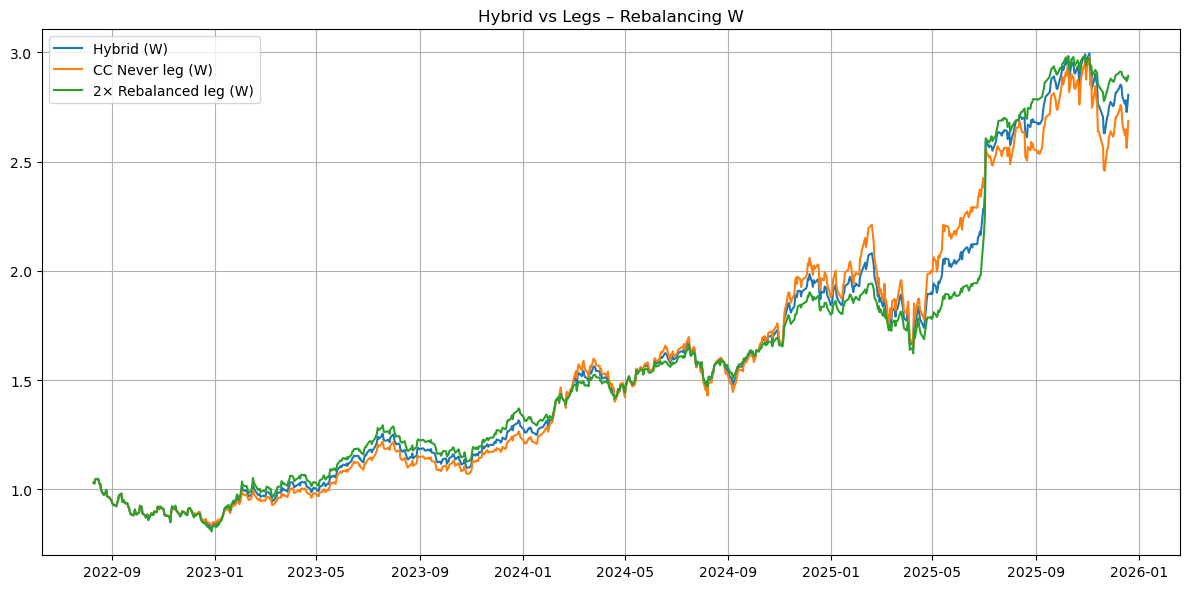

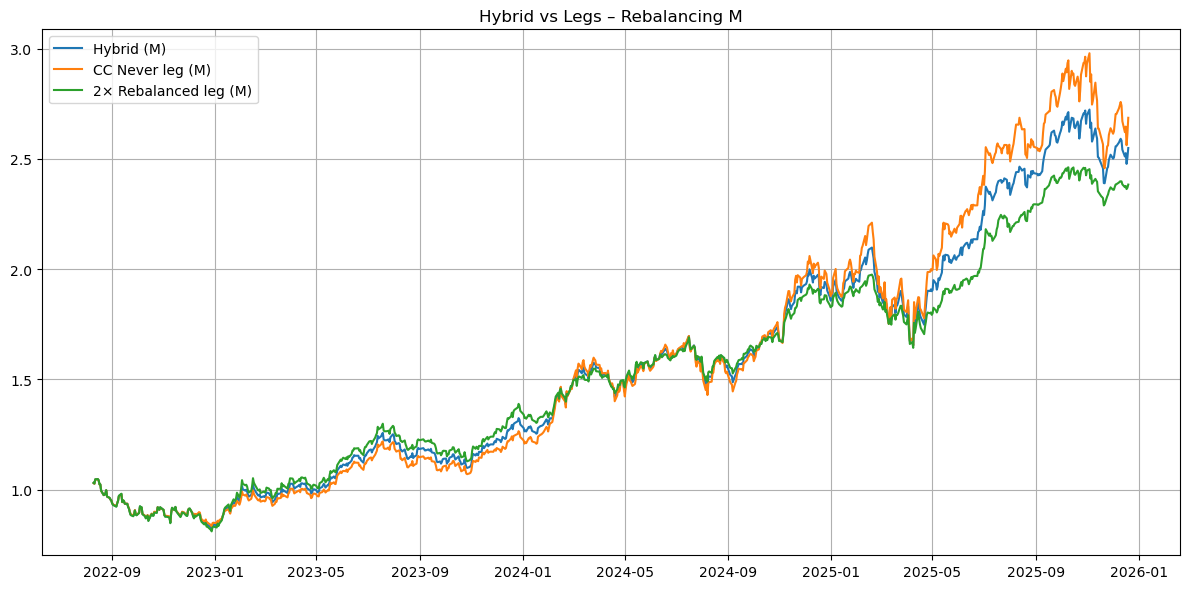

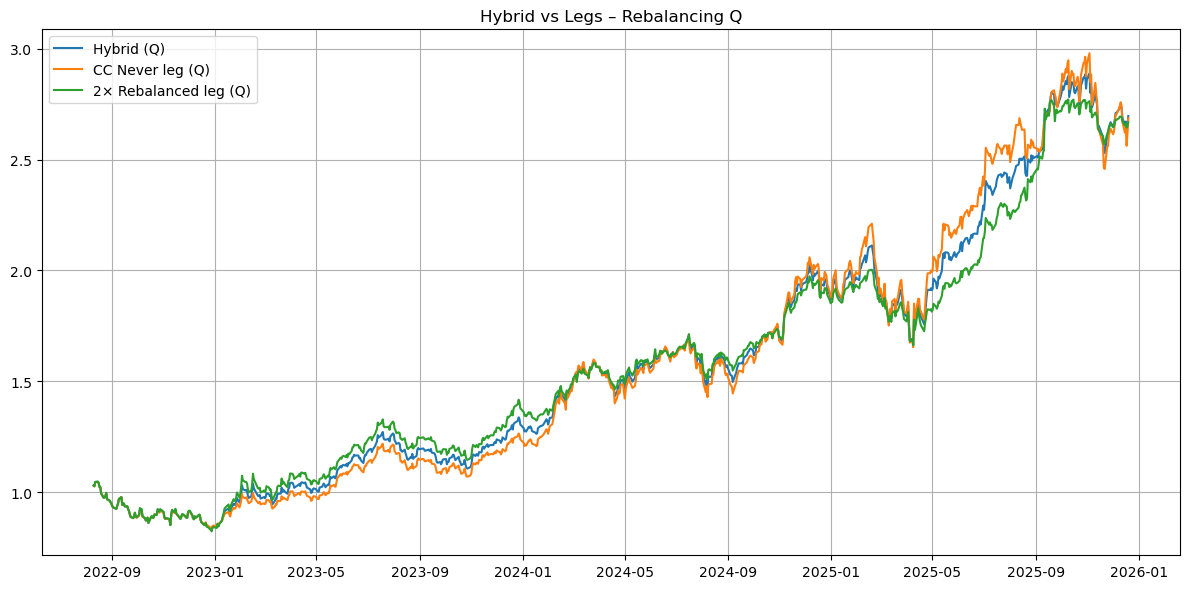


=== Hybrid Rebalancing Frequency Comparison (CC Never, 2x Rebalanced) ===
                      Portfolio  TradingDays     CAGR      Vol     MaxDD
Hybrid: CC-never + Lev2-rebal W          845 0.360245 0.224591 -0.216566
Hybrid: CC-never + Lev2-rebal Q          845 0.344168 0.223049 -0.212548
Hybrid: CC-never + Lev2-rebal M          845 0.321908 0.218945 -0.215138


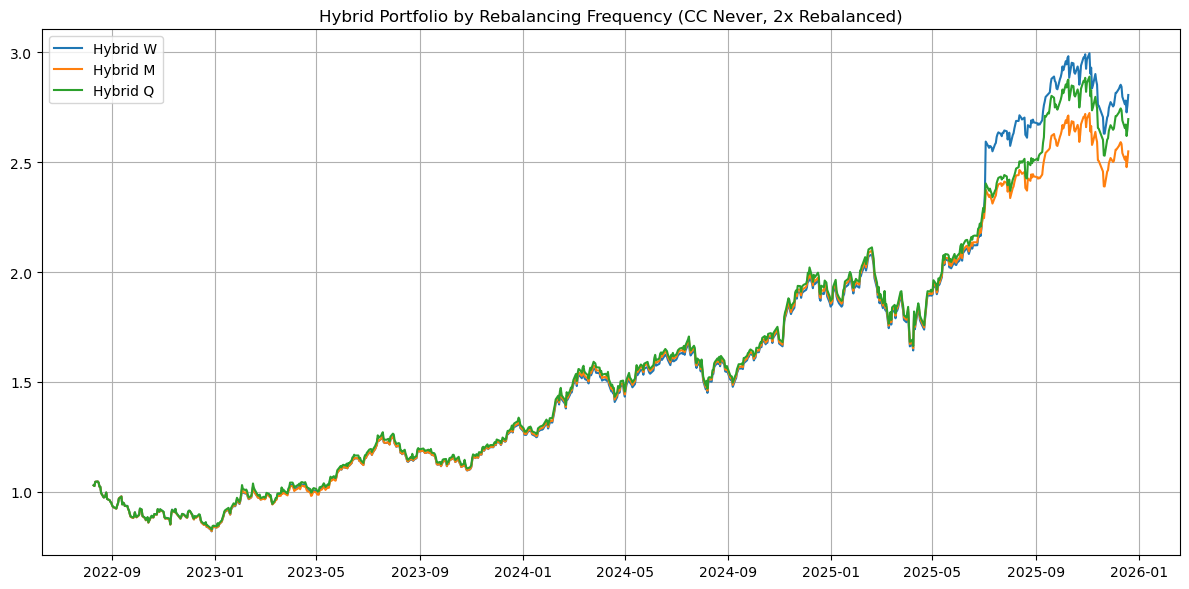

In [154]:
# Assume already defined:
# - rets_bt
# - w_under_by_und
# - w_etf_by_etf
# - borrow_daily_map
# - cc_etfs, lev2_etfs
# - simulate_hybrid_cc_never_and_lev2_rebalanced(...)
# - perf_stats(...)

freqs = ["W", "M", "Q"]

hybrid_curves = {}      # hybrid cumulative curves per freq
results = []            # table of metrics for each freq

for freq in freqs:
    # 1) Run hybrid portfolio for this freq
    hybrid_ret, ret_cc_leg, ret_lev_leg = simulate_hybrid_cc_never_and_lev2_rebalanced(
        rets_bt,
        w_under_by_und,
        w_etf_by_etf,
        borrow_daily_map,
        cc_etfs=cc_etfs,
        lev2_etfs=lev2_etfs,
        freq=freq
    )

    label = f"Hybrid: CC-never + Lev2-rebal {freq}"
    stats = perf_stats(hybrid_ret, label)
    results.append(stats)

    # store cumulative curve for cross-freq plot
    hybrid_curves[freq] = (1 + hybrid_ret).cumprod()

    # 2) Plot Hybrid vs its two legs for this freq
    plt.figure(figsize=(12, 6))
    plt.plot((1 + hybrid_ret).cumprod(), label=f"Hybrid ({freq})")
    plt.plot((1 + ret_cc_leg).cumprod(), label=f"CC Never leg ({freq})")
    plt.plot((1 + ret_lev_leg).cumprod(), label=f"2× Rebalanced leg ({freq})")
    plt.title(f"Hybrid vs Legs – Rebalancing {freq}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3) Nice comparison table across W / M / Q
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("CAGR", ascending=False)
print("\n=== Hybrid Rebalancing Frequency Comparison (CC Never, 2x Rebalanced) ===")
print(results_df.to_string(index=False))

# 4) Plot all three hybrid curves on one chart
plt.figure(figsize=(12, 6))
for freq, curve in hybrid_curves.items():
    plt.plot(curve.index, curve.values, label=f"Hybrid {freq}")
plt.title("Hybrid Portfolio by Rebalancing Frequency (CC Never, 2x Rebalanced)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [155]:
def simulate_hybrid_cc_and_lev2_rebalanced(
    rets,
    w_under,        # Series: underlying weights (by underlying ticker)
    w_etf,          # Series: ETF weights (by ETF ticker)
    borrow_daily_map,
    cc_etfs,
    lev2_etfs,
    cc_freq="M",    # rebalance frequency for CC sleeve: "D","W","M","Q"
    lev_freq="W",   # rebalance frequency for 2x sleeve: "D","W","M","Q"
    sleeve_weight_mode="equal"  # "equal" => 50/50 sleeves, "notional" => by initial gross
):
    """
    Hybrid portfolio:
      • CC sleeve (YM ETFs + shared underlying basket): rebalanced at cc_freq
      • 2× sleeve (DX ETFs + shared underlying basket): rebalanced at lev_freq
      • Combine sleeve returns using either equal 50/50 weights or by initial gross notionals

    Notes:
      - Each sleeve normalizes to 1× gross at *its own* rebalance dates (via simulate_rebalancing_with_weights)
      - Between those dates, weights drift via share/return dynamics
      - No cross-sleeve rebalancing beyond the chosen sleeve_weight_mode
    """

    # 0) Make tz-naive to avoid period grouping mismatches
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    # 1) Split ETF weights into CC vs 2×
    w_etf_cc   = w_etf[w_etf.index.isin(cc_etfs)].copy()
    w_etf_lev2 = w_etf[w_etf.index.isin(lev2_etfs)].copy()

    if w_etf_cc.abs().sum() == 0:
        raise ValueError("No CC ETF exposures found (check cc_etfs / w_etf).")
    if w_etf_lev2.abs().sum() == 0:
        raise ValueError("No 2× ETF exposures found (check lev2_etfs / w_etf).")

    # 2) “Gross notionals” of each sleeve based on the *input* exposures
    #    (used only to weight sleeves when sleeve_weight_mode="notional")
    gross_cc   = w_under.abs().sum() + w_etf_cc.abs().sum()
    gross_lev2 = w_under.abs().sum() + w_etf_lev2.abs().sum()

    # 3) Normalize weights within each sleeve for simulation
    #    (so each sleeve starts at 1× gross internally)
    w_cc_under  = w_under   / gross_cc
    w_cc_etf    = w_etf_cc  / gross_cc

    w_lev_under = w_under     / gross_lev2
    w_lev_etf   = w_etf_lev2  / gross_lev2

    # 4) Simulate each sleeve with its own rebalance frequency
    ret_cc,  _, _ = simulate_rebalancing_with_weights(
        rets_local, w_cc_under,  w_cc_etf,  borrow_daily_map, freq=cc_freq
    )
    ret_lev, _, _ = simulate_rebalancing_with_weights(
        rets_local, w_lev_under, w_lev_etf, borrow_daily_map, freq=lev_freq
    )

    # 5) Align dates
    common_idx = ret_cc.index.intersection(ret_lev.index)
    if common_idx.empty:
        raise ValueError("No overlapping dates between CC and 2× sleeves.")

    ret_cc  = ret_cc.loc[common_idx]
    ret_lev = ret_lev.loc[common_idx]

    # 6) Combine sleeves
    if sleeve_weight_mode == "equal":
        w_cc_sleeve  = 0.5
        w_lev_sleeve = 0.5
    elif sleeve_weight_mode == "notional":
        total = gross_cc + gross_lev2
        w_cc_sleeve  = gross_cc / total
        w_lev_sleeve = gross_lev2 / total
    else:
        raise ValueError("sleeve_weight_mode must be 'equal' or 'notional'.")

    port_ret = w_cc_sleeve * ret_cc + w_lev_sleeve * ret_lev
    return port_ret.dropna(), ret_cc, ret_lev


CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays          Portfolio
      W        W 0.363254 0.205547 -0.228436          845 Hybrid CC=W, Lev=W
      Q        W 0.349165 0.197850 -0.220500          845 Hybrid CC=Q, Lev=W
      Q        Q 0.331777 0.200171 -0.212738          845 Hybrid CC=Q, Lev=Q
      M        W 0.326736 0.193010 -0.226979          845 Hybrid CC=M, Lev=W
      Q        M 0.309891 0.192359 -0.219032          845 Hybrid CC=Q, Lev=M
      M        M 0.288160 0.187177 -0.225521          845 Hybrid CC=M, Lev=M


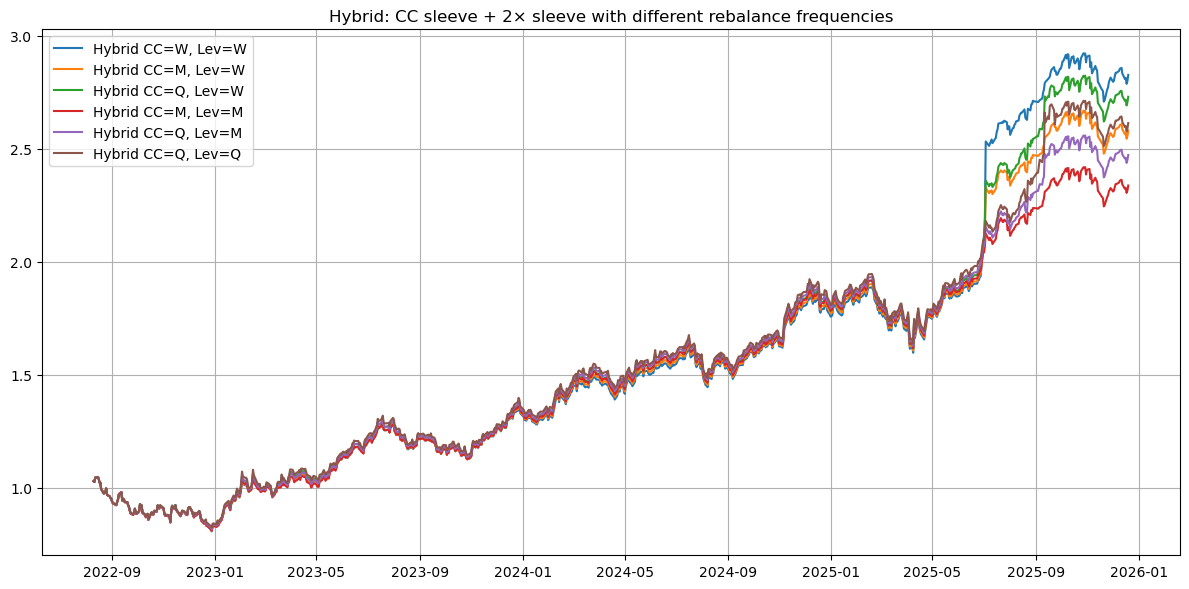

In [156]:
combos = [
    ("W","W"),
    ("M","W"),
    ("Q","W"),
    ("M","M"),
    ("Q","M"),
    ("Q","Q"),
]

results = []
curves = {}

for cc_f, lev_f in combos:
    port_ret, ret_cc, ret_lev = simulate_hybrid_cc_and_lev2_rebalanced(
        rets_bt,
        w_under_by_und,
        w_etf_by_etf,
        borrow_daily_map,
        cc_etfs=cc_etfs,
        lev2_etfs=lev2_etfs,
        cc_freq=cc_f,
        lev_freq=lev_f,
        sleeve_weight_mode="equal"  # or "notional"
    )
    label = f"Hybrid CC={cc_f}, Lev={lev_f}"
    s = perf_stats(port_ret, label)
    results.append({"CC_freq": cc_f, "Lev_freq": lev_f, **s})
    curves[label] = (1 + port_ret).cumprod()

results_df = pd.DataFrame(results).sort_values("CAGR", ascending=False)
print(results_df[["CC_freq","Lev_freq","CAGR","Vol","MaxDD","TradingDays","Portfolio"]].to_string(index=False))

plt.figure(figsize=(12,6))
for label, curve in curves.items():
    plt.plot(curve.index, curve.values, label=label)
plt.title("Hybrid: CC sleeve + 2× sleeve with different rebalance frequencies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [157]:
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    # prefer _TR if present
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            # valid = non-NA (you can also add: & (s != 0) if you want)
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    """
    pairs are (underlying, etf) in your convention.
    returns dict: {(und, etf): start_date}
    """
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue  # cannot trade this pair at all

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def apply_pair_start_mask(pair_rets_df: pd.DataFrame, pair_start_dates: dict, pairs: list[tuple[str,str]]):
    """
    pair_rets_df columns are pair keys like "UND|ETF"
    sets returns to 0 before that pair's start date (i.e., excludes it)
    """
    out = pair_rets_df.copy()
    for und, etf in pairs:
        key = f"{und.upper().replace('.','-')}|{etf.upper().replace('.','-')}"
        if key not in out.columns:
            continue
        start = pair_start_dates.get((und.replace(".","-"), etf.replace(".","-")))
        if start is None:
            # if we somehow created it but don't have a start date, zero it out completely
            out[key] = 0.0
            continue
        out.loc[out.index < start, key] = 0.0
    return out


In [158]:
# Identify largest absolute daily moves in the hybrid
big = hybrid_ret.abs().sort_values(ascending=False).head(10)
print(big)

# Zoom around the biggest day
t0 = big.index[0]
print("Biggest move date:", t0, "ret:", hybrid_ret.loc[t0])
print(hybrid_ret.loc[t0 - pd.Timedelta(days=5): t0 + pd.Timedelta(days=5)])


Date
2025-04-09 04:00:00    0.094597
2022-11-10 05:00:00    0.051358
2025-03-10 04:00:00    0.048182
2025-04-03 04:00:00    0.047847
2024-02-22 05:00:00    0.041812
2025-04-04 04:00:00    0.040451
2024-11-06 05:00:00    0.039929
2025-04-14 04:00:00    0.039442
2025-06-30 04:00:00    0.038827
2023-02-02 05:00:00    0.037827
dtype: float64
Biggest move date: 2025-04-09 04:00:00 ret: 0.09459685956043566
Date
2025-04-04 04:00:00   -0.040451
2025-04-07 04:00:00    0.005724
2025-04-08 04:00:00   -0.017094
2025-04-09 04:00:00    0.094597
2025-04-10 04:00:00   -0.033331
2025-04-11 04:00:00    0.015607
2025-04-14 04:00:00    0.039442
dtype: float64


In [159]:
# Identify largest absolute daily moves in the hybrid
big = hybrid_ret.abs().sort_values(ascending=False).head(10)
print(big)

# Zoom around the biggest day
t0 = big.index[0]
print("Biggest move date:", t0, "ret:", hybrid_ret.loc[t0])
print(hybrid_ret.loc[t0 - pd.Timedelta(days=5): t0 + pd.Timedelta(days=5)])


Date
2025-04-09 04:00:00    0.094597
2022-11-10 05:00:00    0.051358
2025-03-10 04:00:00    0.048182
2025-04-03 04:00:00    0.047847
2024-02-22 05:00:00    0.041812
2025-04-04 04:00:00    0.040451
2024-11-06 05:00:00    0.039929
2025-04-14 04:00:00    0.039442
2025-06-30 04:00:00    0.038827
2023-02-02 05:00:00    0.037827
dtype: float64
Biggest move date: 2025-04-09 04:00:00 ret: 0.09459685956043566
Date
2025-04-04 04:00:00   -0.040451
2025-04-07 04:00:00    0.005724
2025-04-08 04:00:00   -0.017094
2025-04-09 04:00:00    0.094597
2025-04-10 04:00:00   -0.033331
2025-04-11 04:00:00    0.015607
2025-04-14 04:00:00    0.039442
dtype: float64


In [160]:
# Reconstruct levered sleeve weights exactly as in the hybrid

# 1) ETFs belonging to 2x sleeve
w_etf_lev2 = w_etf_by_etf[w_etf_by_etf.index.isin(lev2_etfs)].copy()

# 2) Underlying weights (same underlying basket)
w_under_lev = w_under_by_und.copy()

# 3) Normalize to 1x gross (this is critical)
gross_lev2 = w_under_lev.abs().sum() + w_etf_lev2.abs().sum()

w_lev_under = w_under_lev / gross_lev2
w_lev_etf   = w_etf_lev2 / gross_lev2


In [161]:
ret_lev, w_path_lev, gross_lev = simulate_rebalancing_with_weights(
    rets_bt,
    w_lev_under,
    w_lev_etf,
    borrow_daily_map,
    freq="W"
)


In [162]:
big = ret_lev.abs().sort_values(ascending=False).head(5)
print(big)

t0 = big.index[0]
print("Jump date:", t0, "return:", ret_lev.loc[t0])


Date
2025-07-03 04:00:00    0.157808
2025-06-30 04:00:00    0.074035
2025-04-09 04:00:00    0.070416
2022-11-10 05:00:00    0.057820
2025-04-03 04:00:00    0.040364
dtype: float64
Jump date: 2025-07-03 04:00:00 return: 0.15780829951051284


In [163]:
rets_bt_naive = rets_bt.copy()
if rets_bt_naive.index.tz is not None:
    rets_bt_naive.index = rets_bt_naive.index.tz_convert("UTC").tz_localize(None)

# (Optional) also make sure w_path_lev index is naive (it should already be)
w_path_lev_naive = w_path_lev.copy()
if w_path_lev_naive.index.tz is not None:
    w_path_lev_naive.index = w_path_lev_naive.index.tz_convert("UTC").tz_localize(None)

# Ensure t0 is tz-naive and actually exists in rets index
t0 = pd.Timestamp(t0).to_pydatetime()  # or: t0 = pd.Timestamp(t0).to_datetime64()
t0 = pd.Timestamp(t0)  # ensure Timestamp


In [164]:
t0 = big.index[0]  # from ret_lev (tz-naive)

sym_to_col = {sym: f"{sym}_TR" for sym in w_path_lev.columns if f"{sym}_TR" in rets_bt_naive.columns}

w_prev = w_path_lev.shift(1).loc[t0].dropna()

r_t = rets_bt_naive.loc[t0, [sym_to_col[s] for s in w_prev.index]].rename(
    {sym_to_col[s]: s for s in w_prev.index}
)

contrib = (w_prev * r_t).sort_values(key=lambda x: x.abs(), ascending=False)

print("Top contributors on jump day:")
print(contrib.head(20))

print("\nTop raw returns on jump day:")
print(r_t.sort_values(key=lambda x: x.abs(), ascending=False).head(20))


Top contributors on jump day:
BMNR     0.124002
CRWV     0.000758
IREN     0.000708
OPEN     0.000692
CIFR     0.000659
BE       0.000653
SATS     0.000549
PLTR     0.000447
HOOD    -0.000357
NVDA     0.000341
AMZN     0.000275
MSFT     0.000275
NET      0.000254
PANW     0.000213
BULL     0.000211
GEV      0.000203
PALU    -0.000195
XOM      0.000182
BRK-B    0.000167
NFLX     0.000165
Name: 2025-07-03 04:00:00, dtype: float64

Top raw returns on jump day:
BMNR    1.307692
CRWV    0.088489
OPEN    0.077739
BE      0.074468
IREN    0.074074
CIFR    0.065141
SATS    0.063411
PALU    0.045675
HOOD   -0.036538
CSCL    0.033765
PLTU    0.032359
CRMG    0.031290
NET     0.030328
MSFU    0.029527
AMZU    0.028796
NVDU    0.024796
PANW    0.024623
GEV     0.023700
ETHU   -0.022992
BULL    0.020699
Name: 2025-07-03 04:00:00, dtype: float64
